# Analyzing Trends in Global Terrorism with Bayesian Inference and Timeseries Modeling

There are myriad reasons to maintain and study records of terrorist events. Apart from their inherent value in accurately portraying the political and cultural histories of different regions, terrorism is a clear and persistent threat to free and self-governing societies across the world. Maintaining records of terrorist attacks may help researchers to discover broader patterns in political or ideological violence, whether geographically or over spans of time. In turn, insights derived from the study of terrorism data may assist both governmental and non-governmental agencies in better allocating their resources to prevent or alleviate the effects of future attacks.

To briefly discuss the dataset used for these analysis, I used the Global Terrorism Dataset, which is an open source dataset currently maintained by the National Consortium for the Study of Terrorism and Responses to Terrorism (START) at the University of Maryland (http://start.umd.edu/gtd/). The dataset contains information on over 140,000 recorded terrorist attacks (or suspected terrorist attacks) between 1970 and 2015. However, data from 1993 was lost prior to compilation of the current data set. The dataset contains an extensive amount of information on each attack (where available), including the date and location of each attack, the type of attack (e.g., bombing, armed assault), the weapons used (e.g., firearms, explosives, biological agents), the targets of the attacks, the perpetrators of the attack, and the number of casualties. 

In analyzing the Global Terrorism Database, I set out to address two research objectives. First, I used Bayesian Inference to examine differences in the average number of fatalities in attacks attributed to the Taliban compared to the Islamic State of Iraq and the Levant (or ISIL). Being two of the most prominent terrorist groups in the world today, gauging the respective human costs of their activities can be one metric by which we can evaluate their respective threat to those living within their spheres of influence.

Secondly, I examined data on the number of bombing attacks in the years preceding 1993 in order to generate predictions for the number of bombings that might have occurred for that year. I utilized a few different autoregressive models to analyze the temporal aspects of this data when generating my predictions.

### Bayesian Inference Comparing Average Fatalities in Taliban vs. ISIL Attacks

I utilized Bayesian inference to evaluate the difference in average fatalities caused by the Taliban vs. ISIL in the years following the beginning of major US withdrawal from Afghanistan in August 2012. For this comparison, I only considered attacks with at least one fatality. This means that attacks predominantly targeting non-human targets were discounted from consideration.

The US began troop withdrawals from Iraq in 2007, so beginning troop withdrawal from Afghanistan in 2012 seemed like an appropriate point to capture a period of military drawdown in both the areas where the Taliban and ISIL are active.

For the prior distribution, I examined all fatal terrorist activities (by number of fatalities) in the two regions where these groups are most active (Middle East / North Africa for ISIL and South Asia for the Taliban). I used data from the period spanning US entry in Iraq in March 2003 through the beginning of US withdrawal from Iraq in Dec 2007. Again, the data used in establishing the prior distribution only considered attacks with at least one fatality. This should have helped to capture differences in fatalities caused by these two groups following the withdrawal of US troops from their respective spheres of influence.

To conduct the analysis, I utilized a No U-Turn Sampler to perform Markov Chain Monte Carlo (MCMC) algorithms, deriving 95% Highest Posterior Densities (HPD). # Following this analysis, I could determine a 95% credible interval demonstrating the mean number of fatalities in an ISIL attack to be between 7.94 and 12.13, with a maximum a-posteriori estimate of 10.04 fatalities per attack. I could also determine a 95% credible interval specifying the mean number of fatalities in a Taliban attack being between 4.80 and 5.47, with a maximum a-posteriori estimate of 5.14 fatalities per attack.

Finally, I determined a significant difference in the mean number of fatalities in Taliban attacks when compared to ISIL attacks. With 95% credibility, the mean difference in fatalities per attack for these two groups is between 2.80 and 7.03, with a maximum a-posteriori estimate of 4.90 fatalities’ difference per attack, with ISIL attacks consistently producing more fatalities than Taliban attacks. Knowing this may help non-governmental organizations plan use of their resources to assist and treat victims of terrorist attacks in these groups’ respective areas of influence. Knowing that ISIL attacks consistently lead to higher numbers of fatalities could lead to prioritization or rebalancing of resources to account for higher expected numbers of individuals’ in need of treatment.

### Temporal Analysis to Estimate Number of Bombings in 1993

In order to estimate the number of bombings in 1993, I examined temporal data of recorded bombings through 1992. This estimation was somewhat complicated by an apparent drop-off of bombings in the early 1990s that extended through the rest of the decade. As such, there seemed to be a wide margin for producing 1993 bombing predictions. This drop-off in bombings has been attributed in part to the dissolution of the Soviet Union and the breakup of Yugoslavia and Czechoslovakia around this same time. (Although data indicate that countries experiencing the greatest number of bombings in the five years prior to 1993 were largely in South America.)

I built two separate models to estimate the number of bombings occurring in 1993, one using regional bombing data, and the other utilizing country-specific bombing information.

The first model estimated 1993 bombings using regional bombing data from 1985 to 1992. I chose this period as it appeared to be the most "stationary" period when examining a plot of regional bombings over time. The best means of imposing stationarity on this data required averaging bombings by year across all regions, and then utilizing a single differencing component on an exponential weighted mean of these averaged bombings. Due to the randomness of bombings from year to year, I also included a single moving average component to the model. The first ARIMA (0,1,1) model estimated a total of 1,568 bombings for 1993.

The second model estimated 1993 bombings using country-specific bombing data from 1970 to 1992. While this data appeared considerably “messier” on a country-by-country basis, creating an average of bombings across all countries by year demonstrated a relatively steady upward trend across the years leading up to 1993. The best means of imposing stationarity on this data required averaging bombings by year across all countries, and then utilizing a single differencing component on these averaged bombings. Due to the randomness of bombings from year to year, I also included a single moving average component to the model. The second ARIMA (0,1,1) model estimated a total of 1,580 bombings for 1993.

(Note, in the code below, the country-specific model is reviewed first, followed by the regional model.)

While the two ARIMA models utilized somewhat different methods, I found it encouraging the the predictions generated from these two models were quite similar to one another.

In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm

from pandas.tools.plotting import autocorrelation_plot
#acf = autocorrelative functions; pacf = partial autocorrelative functions
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm

# geo stuff
import geopandas as gpd
from shapely.geometry import Point

# plotting stuff
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = (12.0, 8.0)

# widget stuff
from ipywidgets import interact, HTML, FloatSlider
from IPython.display import clear_output, display


Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
#Obtained data from the Global Terrorism Database website - http://start.umd.edu/gtd/

#I converted the excel file downloaded to csv because the excel file took forever to load in each time I wanted to use
#it. When I saved it, I used (encoding='utf-8'), as pandas initially had trouble handling unicode characters from the 
#original data set.

#reading in the data here represents loading in the csv file I saved as described above.
data = pd.read_csv("globalterrorismdb_0616dist.csv", index_col=0)

/Users/michaelsalmon/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,2,4,5,6,10,14,15,21,28,45,49,51,53,57,61,62,63,67,69,71,86,90,92,117,118,124) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Initial Data Cleaning

In [3]:
print data.duplicated().sum()
#there are 3752 duplicate rows.  We can start by dropping these.
data.drop_duplicates(inplace=True)
data.duplicated().sum()

3752


0

In [4]:
#Convert object types to string and strip whitespace from left and right sides of all column values
for column in data.columns:
    if data[column].dtype == "object":
        data[column] = data[column].astype('str')
        data[column] = data[column].str.strip()

In [5]:
#Replacing all "." and "nan" values with NaN
for column in data.columns:
    data[column].replace(".",np.nan, inplace=True)
    data[column].replace("nan",np.nan, inplace=True)

In [6]:
#I'm not interested in examining incidents that are determined to be unsuccessful terrorist attacks (or where this
#is in doubt). Trying to base predictions of real terrorist attacks off of failed or unsuccessful terrorist attacks 
#could lead to misleading conclusions.  As such, I'm going to drop all rows where success == 0.

non_success = data[data["success"] == 0]
data = data[~data.isin(non_success)].dropna(how='all')

In [7]:
#dropping weird rows where iyear == Phillipines, and where iyear is null

bad_data = data[(data["iyear"] == "Philippines") | (data["iyear"].isnull())]
data = data[~data.isin(bad_data)].dropna(how='all')

In [8]:
#casting date columns as integers
for column in data[["iyear", "imonth", "iday"]]:
    data[column] = data[column].astype('int')
    
#for imonth and iday values equal to zero, assigning random values between 1-12 (for months) and 1-28 (for days)
#received some help from stack overflow for ensuring each new number was random - 
#https://stackoverflow.com/questions/34792089/replace-unique-values-in-a-pandas-dataframe-with-random-numbers

data.loc[data['imonth'] == 0,'imonth'] = data['imonth'].apply(lambda x: np.random.randint(1,13))
data.loc[data['iday'] == 0,'iday'] = data['iday'].apply(lambda x: np.random.randint(1,29))

#to more easily convert to datetime, I need to rename the data columns to just year, month, and day
#thanks for stack overflow: https://stackoverflow.com/questions/19350806/how-to-convert-columns-into-one-datetime-column-in-pandas
data.rename(columns={'iyear':'year', 'imonth':'month', 'iday':'day'}, inplace=True)  

#imputing collected data values over "approxdate" to have singular day for each event
data["approxdate"] = pd.to_datetime(data[["year","month","day"]])

In [9]:
#imputing all -9.0 and -99.00 (and 999.00) values as NaN, checking both for float and string values, just in case
for column in data.columns:
    data[column].replace(-9.0,np.nan, inplace=True)
    data[column].replace(-99.0,np.nan, inplace=True)
    data[column].replace(999.0,np.nan, inplace=True)
    data[column].replace("-9.0",np.nan, inplace=True)   
    data[column].replace("-99.0",np.nan, inplace=True)

In [10]:
#nkill values often listed as decimals. While codebook notes this is to preserve statistical accuracy when dividing
#fatalities across linked events, I rounded these to the nearest whole numbers for ease of calculations
#same goes for nkillus, nkillter, nwound, nwoundus, nwoundte, nhostkid

data[["nkill", "nkillus", "nkillter", "nwound", 
      "nwoundus", "nwoundte", "nhostkid"]] = data[["nkill", "nkillus", "nkillter", "nwound", "nwoundus", 
                                                   "nwoundte", "nhostkid"]].round(0)

In [11]:
data

,eventid,year,month,day,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,1.970000e+11,1970,10,17,1970-10-17,0,NaN,58.0,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0.0,0.0,0.0,0.0,NaN
1,1.970000e+11,1970,6,8,1970-06-08,0,NaN,130.0,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0.0,1.0,1.0,1.0,NaN
2,1.970010e+11,1970,1,19,1970-01-19,0,NaN,160.0,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,NaN,NaN,1.0,1.0,NaN
3,1.970010e+11,1970,1,12,1970-01-12,0,NaN,78.0,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,NaN,NaN,1.0,1.0,NaN
4,1.970010e+11,1970,1,8,1970-01-08,0,NaN,101.0,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,NaN,NaN,1.0,1.0,NaN
5,1.970010e+11,1970,1,1,1970-01-01,0,NaN,217.0,United States,1,...,"The Cairo Chief of Police, William Petersen, r...","""Police Chief Quits,"" Washington Post, January...","""Cairo Police Chief Quits; Decries Local 'Mili...","Christopher Hewitt, ""Political Violence and Te...",Hewitt Project,NaN,NaN,0.0,NaN,NaN
7,1.970010e+11,1970,1,2,1970-01-02,0,NaN,217.0,United States,1,...,"Damages were estimated to be between $20,000-$...",Committee on Government Operations United Stat...,"Christopher Hewitt, ""Political Violence and Te...",NaN,Hewitt Project,NaN,NaN,0.0,NaN,NaN
8,1.970010e+11,1970,1,2,1970-01-02,0,NaN,217.0,United States,1,...,The New Years Gang issue a communiqué to a loc...,"Tom Bates, ""Rads: The 1970 Bombing of the Army...","David Newman, Sandra Sutherland, and Jon Stewa...","The Wisconsin Cartographers' Guild, ""Wisconsin...",Hewitt Project,0.0,0.0,0.0,0.0,NaN
9,1.970010e+11,1970,1,3,1970-01-03,0,NaN,217.0,United States,1,...,"Karl Armstrong's girlfriend, Lynn Schultz, dro...",Committee on Government Operations United Stat...,"Tom Bates, ""Rads: The 1970 Bombing of the Army...","David Newman, Sandra Sutherland, and Jon Stewa...",Hewitt Project,0.0,0.0,0.0,0.0,NaN
11,1.970011e+11,1970,1,6,1970-01-06,0,NaN,217.0,United States,1,...,NaN,Committee on Government Operations United Stat...,"Christopher Hewitt, ""Political Violence and Te...",NaN,Hewitt Project,NaN,NaN,0.0,NaN,NaN


In [12]:
#looking at full list of columns
list(data.columns)

['eventid',
 'year',
 'month',
 'day',
 'approxdate',
 'extended',
 'resolution',
 'country',
 'country_txt',
 'region',
 'region_txt',
 'provstate',
 'city',
 'latitude',
 'longitude',
 'specificity',
 'vicinity',
 'location',
 'summary',
 'crit1',
 'crit2',
 'crit3',
 'doubtterr',
 'alternative',
 'alternative_txt',
 'multiple',
 'success',
 'suicide',
 'attacktype1',
 'attacktype1_txt',
 'attacktype2',
 'attacktype2_txt',
 'attacktype3',
 'attacktype3_txt',
 'targtype1',
 'targtype1_txt',
 'targsubtype1',
 'targsubtype1_txt',
 'corp1',
 'target1',
 'natlty1',
 'natlty1_txt',
 'targtype2',
 'targtype2_txt',
 'targsubtype2',
 'targsubtype2_txt',
 'corp2',
 'target2',
 'natlty2',
 'natlty2_txt',
 'targtype3',
 'targtype3_txt',
 'targsubtype3',
 'targsubtype3_txt',
 'corp3',
 'target3',
 'natlty3',
 'natlty3_txt',
 'gname',
 'gsubname',
 'gname2',
 'gsubname2',
 'gname3',
 'ingroup',
 'ingroup2',
 'ingroup3',
 'gsubname3',
 'motive',
 'guncertain1',
 'guncertain2',
 'guncertain3',
 'npe

In [13]:
#spare thoughts unaddressed by data cleanup above:

#clean up "crit2" what does ISVG mean for this column?
# 2.0 for claimed - examine claimmode for 2.0 to see if imputation is possible?
#0.0 for claimmode, impute as NaN?
#for claimmode_txt, 0 values

#values of 0 and 479 in "alternative" - 479 could probably be 4 - check "alternative_txt" for correspondance
#some "summary" values are duplicated, as they were part of a series of related attacks within a short time frame
    #possible implications for NLP if they're all the same?

#propextent == 4 == unknown - is this equivalent to NaN?    
#propvalue is the property value of damage at the time of the attack (not adjusted for inflation)

#ultimately, I decided to leave these columns alone, given that I didn't include them in my analyses.  
#There are so many columns with majority null values, it's not worth it to try to fully clean up the dataframe and 
#eliminate all of the columns I don't care to use.  

#Any further cleaning can be done in a piecemeal fashion from here.

#other initial reactions:
#use NLP on attack descriptions/notes?  What kinds of information do these columns hold, and is it important
#for analytical purposes here? (I didn't end up getting around to this within the time allowed)

## Generating Plot and Widget to Explore Terror Attacks by Year

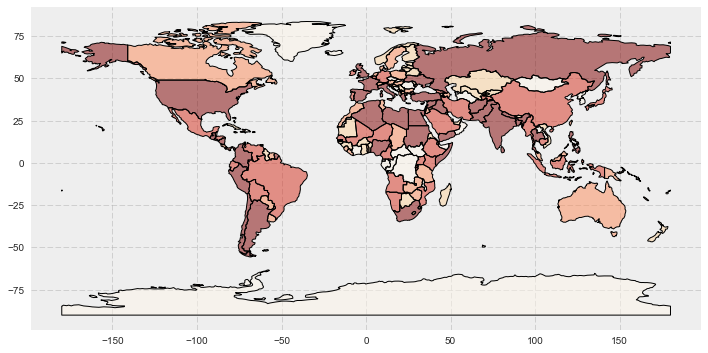

In [15]:
#reading in world dataset from geopandas

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

#grouping terror attacks by country 
country_terr = pd.DataFrame(data.groupby("country_txt").eventid.count())
country_terr.reset_index(inplace=True)

#merging country_terr onto world, joining on country name
#doing left merge to preserve countries that don't have any listed terror attacks
world_terr = pd.merge(world, country_terr, how='left', left_on='name', right_on='country_txt')

#filling NaN values with 0 if countries have no listed terror attacks
world_terr.eventid.fillna(0.0,inplace=True)
#plotting terror countries
world_terr.plot(column='eventid', cmap='OrRd',scheme='quantiles')  #countries colored by terrorism, coloring orange-red 
#coloring in proportionally using "quantiles"

#surprisingly, the US is rather high on the list

<function __main__.make_plot>

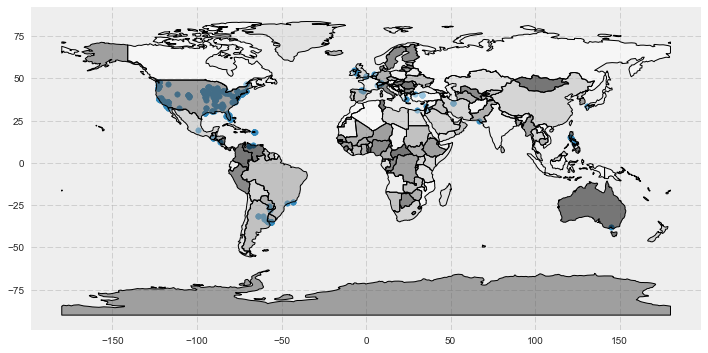

In [16]:
#now, creating widget
terr_world = pd.merge(data, world, how='left', left_on='country_txt', right_on='name')

#for simplicity's sake, filtering out all rows that didn't easily merge
terr_world = terr_world[terr_world["geometry"].notnull()]

#It took me a long time to figure out that the to_datetime wasn't converting dates as I anticipated. I had to specify
#the format as just the year in order for the data to convert properly.
terr_world["year"] = pd.to_datetime(terr_world["year"], format='%Y')

#converting lat/long to float for easier use with widget
terr_world["longitude"] = terr_world["longitude"].astype(float)
terr_world["latitude"] = terr_world["latitude"].astype(float)

def make_plot(year=1970):

    # filter dataframe
    temp = terr_world[terr_world['doubtterr']==0]
    temp=temp[temp['year'].dt.year==year]

    # plot
    world.plot()
    plt.scatter(x=temp['longitude'], y=temp['latitude'], s=30)

# create widget
interact(make_plot, year=(1970, 2015, 1))



## Examining Attack Types

In [17]:
#Looking at data on the consolidated number of attacks by type over the years
data.attacktype1_txt.value_counts()

Bombing/Explosion                      67882
Armed Assault                          35962
Assassination                          13612
Hostage Taking (Kidnapping)             8908
Facility/Infrastructure Attack          8324
Unknown                                 4967
Hostage Taking (Barricade Incident)      827
Unarmed Assault                          698
Hijacking                                481
Name: attacktype1_txt, dtype: int64

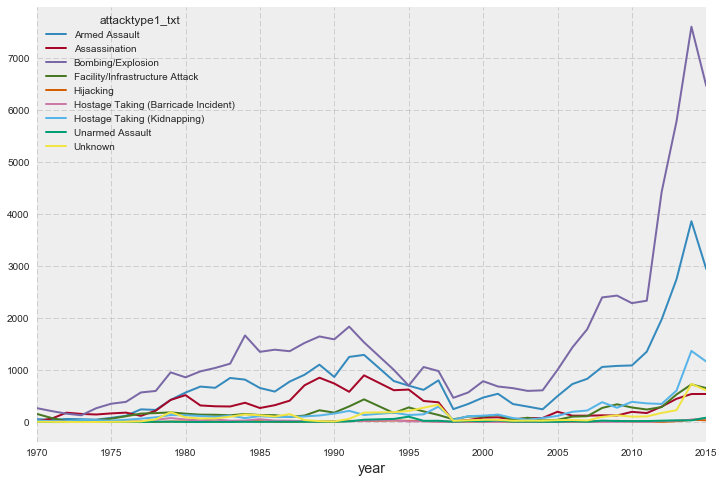

In [18]:
#Looking at trend of attack types over all years
attacks_time = data[["year","attacktype1_txt"]].groupby(["year","attacktype1_txt"]).attacktype1_txt.count().unstack()
attacks_time.fillna(0,inplace=True)
attacks_time.plot()


In [19]:
#Apart from "Unknown" attacks, the big three categories over time appear to be Bombing/Explosion, Armed Assault, and 
#Assassination, which makes sense given the sum totals calculated above.  It is quite remarkable to see the increase in
#terror attacks beginning around 2003-2004 - right around the time the US invaded Iraq.

#Also worth mentioning here is that, despite having no data for 1993, the overall charting of attacks doesn't seem 
#greatly disrupted by that lack of data.

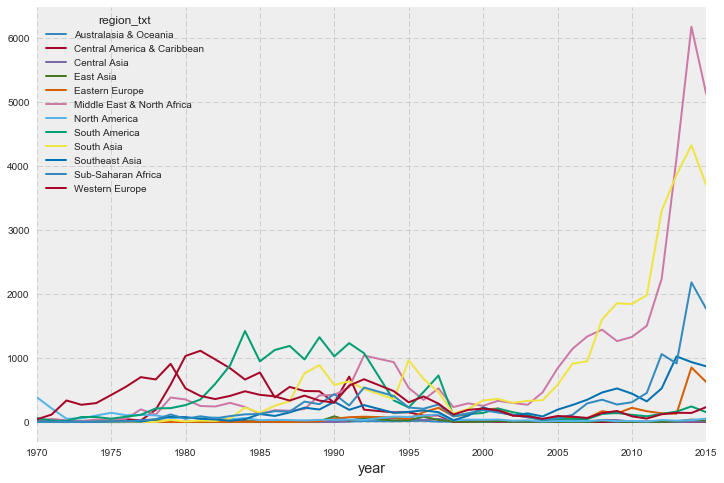

In [20]:
#examining attacks by region over time
attacks_region = data[["year","region_txt"]].groupby(["year","region_txt"]).region_txt.count().unstack()
attacks_region.fillna(0,inplace=True)
attacks_region.plot()

In [21]:
attacks_region

region_txt,Australasia & Oceania,Central America & Caribbean,Central Asia,East Asia,Eastern Europe,Middle East & North Africa,North America,South America,South Asia,Southeast Asia,Sub-Saharan Africa,Western Europe
year,,,,,,,,,,,,
1970,1.0,7.0,0.0,2.0,12.0,23.0,389.0,60.0,1.0,9.0,3.0,42.0
1971,1.0,4.0,0.0,1.0,3.0,49.0,214.0,24.0,0.0,5.0,2.0,116.0
1972,2.0,3.0,0.0,0.0,1.0,27.0,52.0,18.0,1.0,8.0,0.0,337.0
1973,1.0,4.0,0.0,2.0,1.0,15.0,56.0,78.0,0.0,2.0,4.0,270.0
1974,1.0,11.0,0.0,4.0,2.0,39.0,101.0,78.0,2.0,3.0,7.0,296.0
1975,0.0,8.0,0.0,12.0,0.0,43.0,145.0,52.0,4.0,7.0,12.0,422.0
1976,0.0,44.0,0.0,1.0,0.0,51.0,106.0,83.0,4.0,12.0,8.0,552.0
1977,0.0,24.0,0.0,4.0,2.0,198.0,112.0,113.0,2.0,7.0,27.0,702.0
1978,2.0,192.0,0.0,29.0,2.0,114.0,104.0,213.0,2.0,43.0,44.0,666.0


In [22]:
#Also unsurpringly, the majority of recent attacks have been occuring in the Middle East (which includes Iraq and Syria),
#South Asia (which includes Afghanistan), and, to a lesser extent, Sub-Saharan Africa (due to Boko Haram in Nigeria).

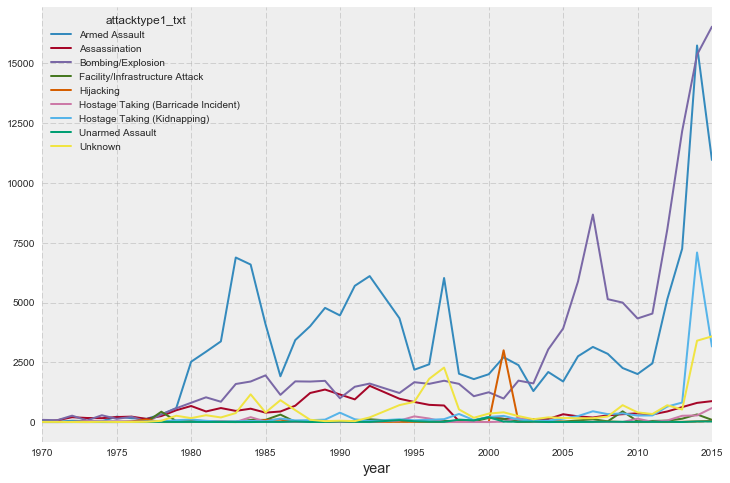

In [23]:
#Looking at trend of numbers of people killed by attack types over all years
fatalities_time = data[["year","attacktype1_txt", "nkill"]].groupby(["year","attacktype1_txt"]).nkill.sum().unstack()
fatalities_time.fillna(0,inplace=True)
fatalities_time.plot()

In [24]:
#again, Bombing/Explosion and Armed Assault have among the highest fatality counts in recent years, nearly tieing 
#each other in 2014.  There's a large spike for Hijacking in 2001, due to 9/11

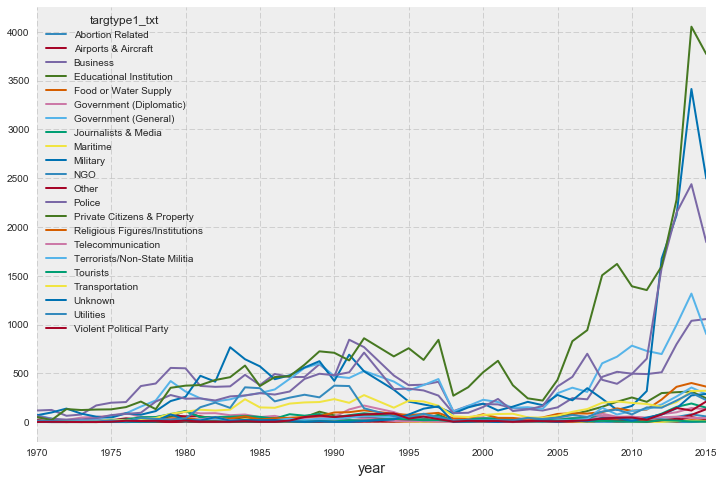

In [25]:
#examining attacks by target over time
attacks_target = data[["year","targtype1_txt"]].groupby(["year","targtype1_txt"]).targtype1_txt.count().unstack()
attacks_target.fillna(0,inplace=True)
attacks_target.plot()


In [26]:
#examining top targets in 2015
attacks_target.iloc[44,:].sort_values(ascending=False)

#Private citizens/property are top, followed by military, police, businesses, and government (general).
#these five targets appear to standout from other targets for most years. 

targtype1_txt
Private Citizens & Property       3773.0
Military                          2496.0
Police                            1844.0
Business                          1056.0
Government (General)               901.0
Religious Figures/Institutions     363.0
Transportation                     321.0
Unknown                            288.0
Terrorists/Non-State Militia       286.0
Educational Institution            243.0
Utilities                          224.0
Violent Political Party            211.0
Journalists & Media                147.0
Other                              132.0
Government (Diplomatic)            132.0
NGO                                 57.0
Telecommunication                   40.0
Airports & Aircraft                 26.0
Food or Water Supply                12.0
Maritime                             7.0
Tourists                             5.0
Abortion Related                     4.0
Name: 2015, dtype: float64

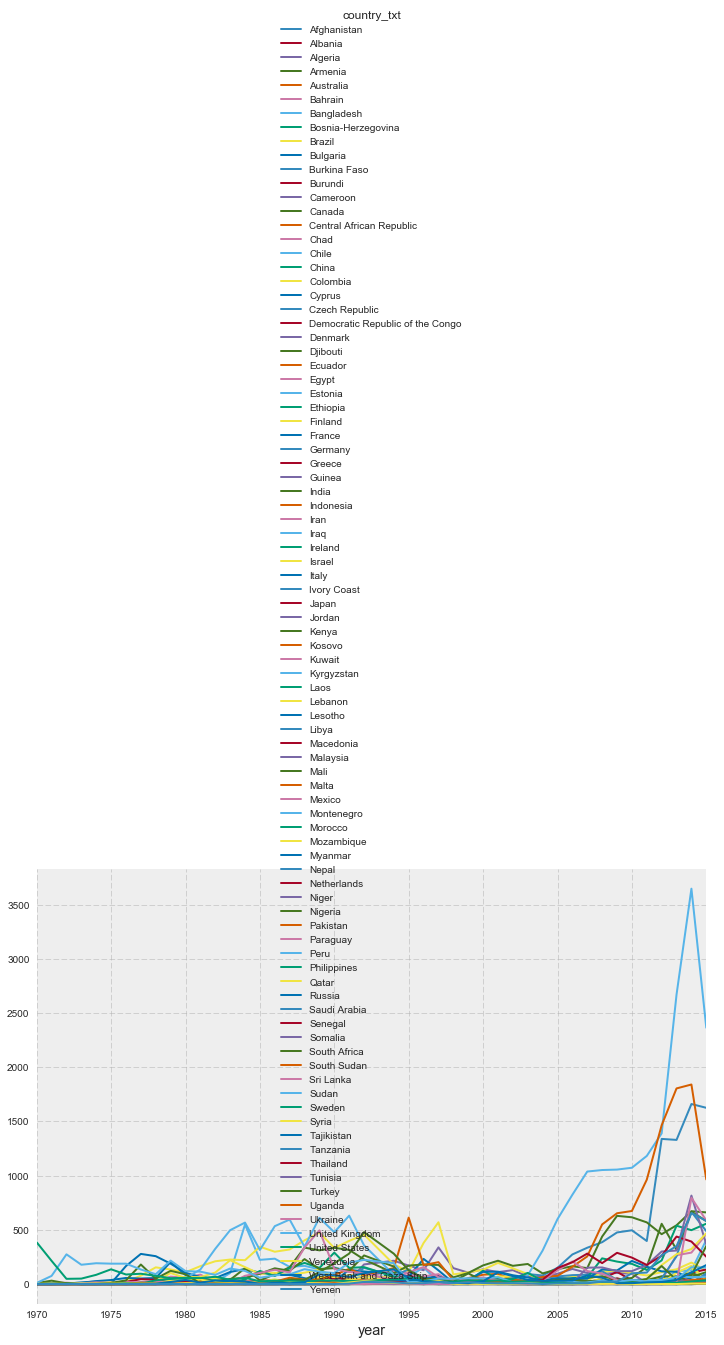

In [27]:
#examining attacks by country over time
attacks_country = data[["year","country_txt"]].groupby(["year","country_txt"]).country_txt.count().unstack()
attacks_country.fillna(0,inplace=True)

#filtering only countries that had attacks in 2015
attacks_2015 = attacks_country.iloc[44,:] > 0
attacks_2015 = attacks_2015[attacks_2015 == True]

attacks_country = attacks_country.filter(items=attacks_2015.index)
attacks_country.plot()

In [28]:
#with the messiness of the plot above, looking at countries with the greatest numbers of attacks in 2015
attacks_country.iloc[44,:].sort_values(ascending=False)

#again, unsurprisingly, Iraq and Afghanistan are at the top of the list - Pakistan and India continue to have problems,
#and Ukraine has had its border issues with Russia

country_txt
Iraq                                2365.0
Afghanistan                         1626.0
Pakistan                             965.0
India                                661.0
Ukraine                              586.0
Yemen                                582.0
Nigeria                              581.0
Philippines                          557.0
Libya                                488.0
Syria                                469.0
Egypt                                461.0
Bangladesh                           408.0
Somalia                              366.0
Turkey                               352.0
Thailand                             252.0
West Bank and Gaza Strip             175.0
Sudan                                152.0
Democratic Republic of the Congo     134.0
Colombia                             123.0
Mali                                 110.0
Saudi Arabia                          97.0
Burundi                               90.0
Cameroon                              79.0

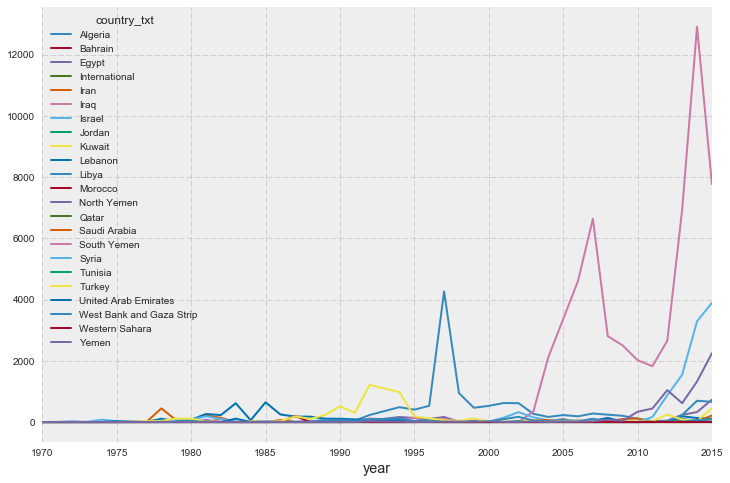

In [29]:
#Looking at trend of numbers of people killed in different regions over all years
#first Middle East
mid_east = data[data["region_txt"] == "Middle East & North Africa"]

fatalities_me_time = mid_east[["year","country_txt", "nkill"]].groupby(["year","country_txt"]).nkill.sum().unstack()
fatalities_me_time.fillna(0,inplace=True)
fatalities_me_time.plot()

In [30]:
#Iraq and Syria are standouts here, with Yemen also having plenty of problems.
fatalities_me_time.iloc[44,:].sort_values(ascending=False)


country_txt
Iraq                        7773.0
Syria                       3893.0
Yemen                       2249.0
Egypt                        730.0
Libya                        661.0
Turkey                       452.0
Saudi Arabia                 213.0
Lebanon                      109.0
Tunisia                      103.0
West Bank and Gaza Strip      85.0
Iran                          38.0
Kuwait                        28.0
Algeria                       20.0
Israel                        16.0
Jordan                         7.0
Bahrain                        5.0
Western Sahara                 0.0
North Yemen                    0.0
Qatar                          0.0
South Yemen                    0.0
International                  0.0
United Arab Emirates           0.0
Morocco                        0.0
Name: 2015, dtype: float64

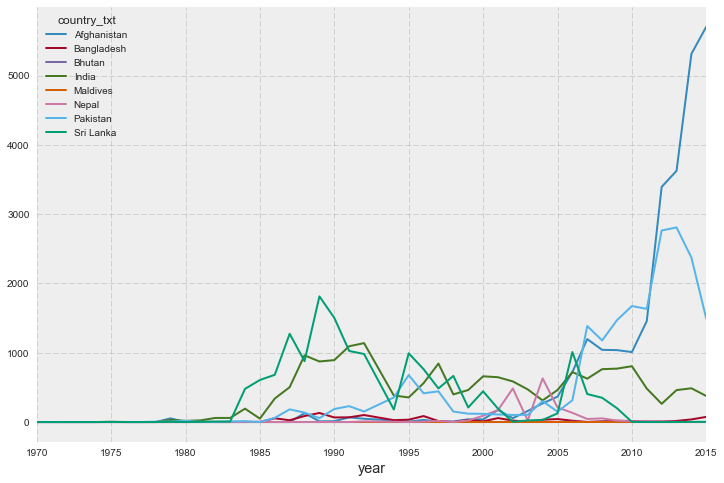

In [31]:
#Looking at trend of numbers of people killed in different regions over all years
#now South Asia
south_asia = data[data["region_txt"] == "South Asia"]

fatalities_sa_time = south_asia[["year","country_txt", "nkill"]].groupby(["year","country_txt"]).nkill.sum().unstack()
fatalities_sa_time.fillna(0,inplace=True)
fatalities_sa_time.plot()

In [32]:
#Examining 2015 fatalities by country in south asia - Afghanistan, Pakistan, and India (to a lesser extent) top the
#boards
fatalities_sa_time.iloc[42,:].sort_values(ascending=False)


country_txt
Afghanistan    5707.0
Pakistan       1490.0
India           376.0
Bangladesh       74.0
Sri Lanka         3.0
Nepal             0.0
Maldives          0.0
Bhutan            0.0
Name: 2015, dtype: float64

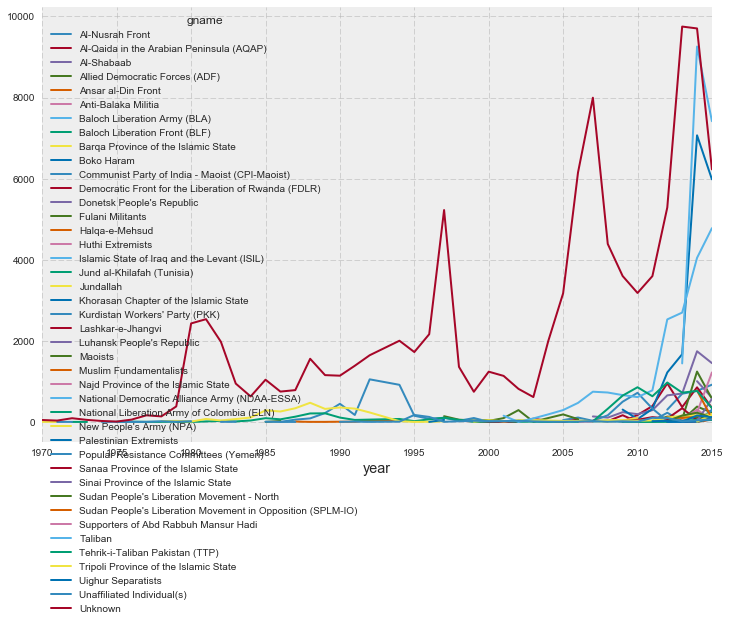

In [33]:
#Looking at fatalities linked to different terror groups with at least 50 fatalities in 2015

groups = data[["year","gname", "nkill"]].groupby(["year","gname"]).nkill.sum().unstack()

groups_2015 = groups.iloc[44,:] > 50
groups_2015 = groups_2015[groups_2015 == True]
groups_2015

attacks_group = groups.filter(items=groups_2015.index)
attacks_group.plot()

In [34]:
#Examining top terrorist groups in 2015 by number of fatalities (having at least 50 attributed fatalities)
attacks_group.iloc[44,:].sort_values(ascending=False)

#Apart from unknown/unaffiliated terrorists, ISIL, Boko Haram, and the Taliban are clearly the most active/deadly
#groups in 2015.

gname
Islamic State of Iraq and the Levant (ISIL)                   7417.0
Unknown                                                       6228.0
Boko Haram                                                    5983.0
Taliban                                                       4778.0
Al-Shabaab                                                    1450.0
Huthi Extremists                                              1220.0
Al-Nusrah Front                                                918.0
Donetsk People's Republic                                      597.0
Fulani Militants                                               572.0
Sinai Province of the Islamic State                            569.0
Al-Qaida in the Arabian Peninsula (AQAP)                       343.0
Tehrik-i-Taliban Pakistan (TTP)                                341.0
Khorasan Chapter of the Islamic State                          298.0
Sanaa Province of the Islamic State                            292.0
Kurdistan Workers' Party (PK

In [35]:
#looking at the countries and regions Boko Haram, the Taliban, and ISIL have been active in terms of 
#number of fatalities

boko_country = data[data["gname"] == "Boko Haram"].groupby("country_txt").nkill.sum()
print "Boko Haram Fatalities by Country: ", boko_country.sort_values(ascending=False)
print
boko_region = data[data["gname"] == "Boko Haram"].groupby("region_txt").nkill.sum()
print "Boko Haram Fatalities by Region: ", boko_region.sort_values(ascending=False)


Boko Haram Fatalities by Country:  country_txt
Nigeria         14088.0
Cameroon         1662.0
Niger             570.0
Chad              312.0
Burkina Faso        1.0
Name: nkill, dtype: float64

Boko Haram Fatalities by Region:  region_txt
Sub-Saharan Africa    16633.0
Name: nkill, dtype: float64


In [36]:
tali_country = data[data["gname"] == "Taliban"].groupby("country_txt").nkill.sum()
print "Taliban Fatalities by Country: ", tali_country.sort_values(ascending=False)
print
tali_region = data[data["gname"] == "Taliban"].groupby("region_txt").nkill.sum()
print "Taliban Fatalities by Region: ", tali_region.sort_values(ascending=False)


Taliban Fatalities by Country:  country_txt
Afghanistan     18596.0
Pakistan          156.0
Turkmenistan        3.0
Name: nkill, dtype: float64

Taliban Fatalities by Region:  region_txt
South Asia      18752.0
Central Asia        3.0
Name: nkill, dtype: float64


In [37]:
isil_country = data[data["gname"] == "Islamic State of Iraq and the Levant (ISIL)"].groupby("country_txt").nkill.sum()
print "ISIL Fatalities by Country: ", isil_country.sort_values(ascending=False)
print
isil_region = data[data["gname"] == "Islamic State of Iraq and the Levant (ISIL)"].groupby("region_txt").nkill.sum()
print "ISIL Fatalities by Region: ", isil_region.sort_values(ascending=False)


ISIL Fatalities by Country:  country_txt
Iraq                        13885.0
Syria                        3722.0
Turkey                        205.0
France                        136.0
Lebanon                       117.0
Saudi Arabia                   15.0
Tunisia                        14.0
Egypt                          10.0
Libya                           7.0
Jordan                          6.0
West Bank and Gaza Strip        0.0
Somalia                         0.0
Israel                          0.0
Bahrain                         0.0
Name: nkill, dtype: float64

ISIL Fatalities by Region:  region_txt
Middle East & North Africa    17981.0
Western Europe                  136.0
Sub-Saharan Africa                0.0
Name: nkill, dtype: float64


In [38]:
data[data["gname"] == "Islamic State of Iraq and the Levant (ISIL)"]


,eventid,year,month,day,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
116002,2.013042e+11,2013,4,18,2013-04-18,0,NaN,95.0,Iraq,10,...,Casualty numbers for this incident conflict ac...,"""Suicide attack kills 26 in Iraq,"" New Straits...","""Suicide bomber kills at least 27 in Baghdad c...","""Bombing kills 32 at Baghdad cafe ahead of vot...",START Primary Collection,NaN,NaN,0.0,NaN,NaN
116074,2.013042e+11,2013,4,20,2013-04-20,0,NaN,95.0,Iraq,10,...,NaN,"""Iraqis vote in local elections despite violen...","""Poll centre attacks mar Iraq provincial vote,...","""Bombings mar start to milestone Iraq election...",START Primary Collection,NaN,NaN,0.0,NaN,"201304200019, 201304200020"
116075,2.013042e+11,2013,4,20,2013-04-20,0,NaN,95.0,Iraq,10,...,NaN,"""Iraqis vote in local elections despite violen...","""UPDATE 1-Bombs mar start to first Iraq vote s...","""Scattered violence in Iraq's first elections ...",START Primary Collection,NaN,NaN,0.0,NaN,"201304200018, 201304200020"
116076,2.013042e+11,2013,4,20,2013-04-20,0,NaN,95.0,Iraq,10,...,NaN,"""Iraqis vote in local elections despite violen...","""UPDATE 1-Bombs mar start to first Iraq vote s...","""Scattered violence in Iraq's first elections ...",START Primary Collection,NaN,NaN,0.0,NaN,"201304200018, 201304200019"
116819,2.013051e+11,2013,5,11,2013-05-11,0,NaN,209.0,Turkey,10,...,Casualty numbers for this incident conflict ac...,"""Turkey 'arrests terror suspects',"" BBC, May 3...","""Death toll in Turkey car bombings rises to 51...","""Turkey twin bombings death toll rises to 48,""...",START Primary Collection,1.0,1.0,1.0,1.0,201305110008
116820,2.013051e+11,2013,5,11,2013-05-11,0,NaN,209.0,Turkey,10,...,Casualty numbers for this incident conflict ac...,"""Turkey 'arrests terror suspects',"" BBC, May 3...","""Death toll in Turkey car bombings rises to 51...","""Turkey opens trial over deadly ReyhanlÄ± bomb...",START Primary Collection,1.0,1.0,1.0,1.0,201305110007
117009,2.013052e+11,2013,5,16,2013-05-16,0,NaN,95.0,Iraq,10,...,Casualty numbers for this attack conflict acro...,"""3 people killed in car bombing in Baghdad Shi...","""Car bombs, shooting in Iraq leave 15 people d...",NaN,START Primary Collection,NaN,NaN,0.0,NaN,"201305160007, 201305160008"
117010,2.013052e+11,2013,5,16,2013-05-16,0,NaN,95.0,Iraq,10,...,NaN,"""Car bombs, shooting in Iraq leave 15 people d...",NaN,NaN,START Primary Collection,NaN,NaN,0.0,NaN,"201305160006, 201305160008"
117011,2.013052e+11,2013,5,16,2013-05-16,0,NaN,95.0,Iraq,10,...,NaN,"""Car bombs, shooting in Iraq leave 15 people d...",NaN,NaN,START Primary Collection,NaN,NaN,0.0,NaN,"201305160006, 201305160007"
117012,2.013052e+11,2013,5,16,2013-05-16,0,NaN,95.0,Iraq,10,...,Casualty numbers for this attack conflict acro...,"""Wave of bombings, shootings kills 11 in Iraq,...","""Car bombs, shooting in Iraq leave 15 people d...",NaN,START Primary Collection,NaN,NaN,0.0,NaN,NaN


## Bayesian Inference - Average Fatalities caused by the Taliban vs. ISIL (2012-2015)

In [39]:
#In terms of a Baysian comparison - I'm going to evaluate the difference in average fatalities caused by the Taliban 
#vs. ISIL in the years following the beginning of major US withdrawl from Afghanistan in August 2012. For this 
#comparison, I'm only going to count attacks with at least one fatality. This will mean that attacks predominantly
#targeting non-human targets will be discounted from consideration here. 

#The US began troop withdrawl from Iraq in 2007, so beginning troop withdrawl from Afghanistan seems like an 
#appropriate point to capture a period of military drawdown in both of the areas where the Taliban and ISIL are active. 
#As well, the first recorded ISIL attack came in 2013, so beginning the period of observation in 2011 should not 
#hamper our findings to any great degree.

#For our prior, we will examine all fatal terrorist activities (by number of fatalities) in the two regions where these 
#groups are most active (Middle East & North Africa and South Asia) from US entry in Iraq in March 2003 through the
#beginning of US withdrawl from Iraq in Dec 2007. Again, the prior will only consider attacks with at least one 
#fatality.

#This should hopefully help to capture the differences in fatalities caused by these two groups following the withdrawl
#of US troops from their respective spheres of influence.

In [40]:
#drawing out number of fatalities for each incident caused by the Taliban and ISIL in August 2012 and beyond:
#We're going to filter out all attacks with 0 or NaN values for nkill.

tali_fats1 = data[(data["gname"] == "Taliban") & (data["approxdate"] > "2012-07-31") & 
                 (data["nkill"] != 0.0) & (data["nkill"].notnull())]  
tali_fats = tali_fats1.nkill.values

isil_fats1 = data[(data["gname"] == "Islamic State of Iraq and the Levant (ISIL)") & (data["approxdate"] > "2012-07-31") 
                 & (data["nkill"] != 0.0) & (data["nkill"].notnull())] 
isil_fats = isil_fats1.nkill.values

#examining the distribution of fatalities for all attacks in the regions where ISIL and the Taliban are most active
#between March 2003 and Dec 2007
#We're going to filter out all attacks with 0 or NaN values for nkill.

regional_fats1 = data[((data["region_txt"] == "Middle East & North Africa") | (data["region_txt"] == "South Asia")) &
                    (data["approxdate"] > "2003-03-01") & (data["approxdate"] < "2007-12-01") & (data["nkill"] != 0.0) 
                     & (data["nkill"].notnull())]  
regional_fats = regional_fats1.nkill.values



In [41]:
#Wanting to generate a timeseries plot comparing average taliban and ISIL fatalities in period of interest to regional
#averages of fatalities during prior period

#separating out mean fatality numbers by year for individual groups
tali_plot = pd.DataFrame(tali_fats1[["year","gname", "nkill"]].groupby(["year","gname"]).nkill.mean().unstack())
isil_plot = pd.DataFrame(isil_fats1[["year","gname", "nkill"]].groupby(["year","gname"]).nkill.mean().unstack())

#separating out mean fatalitiy information from regional bases, generating and isolating "average" column
regional_plot = pd.DataFrame(regional_fats1[["year","gname", "nkill"]].groupby(["year","gname"]).nkill.mean().unstack())
regional_plot.fillna(0.0, inplace=True)
regional_plot["Regional Prior Average"] = regional_plot.mean(axis=1)
regional_plot = pd.DataFrame(regional_plot["Regional Prior Average"])

#concatenating all dfs together for purposes of plotting
bayes_plot = pd.concat([regional_plot, tali_plot, isil_plot], axis=1)


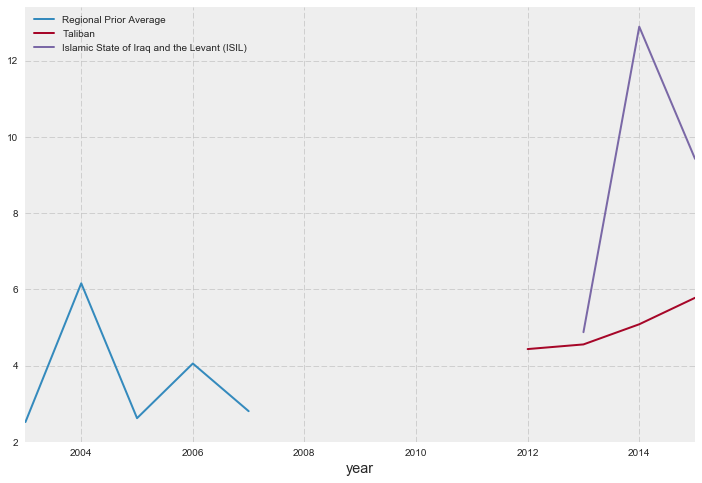

In [42]:
bayes_plot.plot()

#unfortunately, it's kind of an underwhelming figure (I hoped to use this in my presentation, but it hardly seems
#worthwhile). It makes sense that these two groups tend to be above the prior average, as they are standouts among
#all terror groups in their respective regions. 

In [43]:
#throwing together a simple dataframe so I can make a barplot comparing average fatalities between prior distribution
#and specific groups I'm comparing

quick_bayes_plot = pd.DataFrame(pd.concat([pd.DataFrame(data=[regional_fats1.nkill.mean()]), tali_fats1.groupby(["gname"]).nkill.mean(), isil_fats1.groupby(["gname"]).nkill.mean()],axis=0))
quick_bayes_plot.index.values[0] = "Regional Average"
quick_bayes_plot.reset_index(inplace=True)
quick_bayes_plot.columns = ["group","nkill"]
quick_bayes_plot

,group,nkill
0,Regional Average,6.210889
1,Taliban,5.135481
2,Islamic State of Iraq and the Levant (ISIL),10.059411


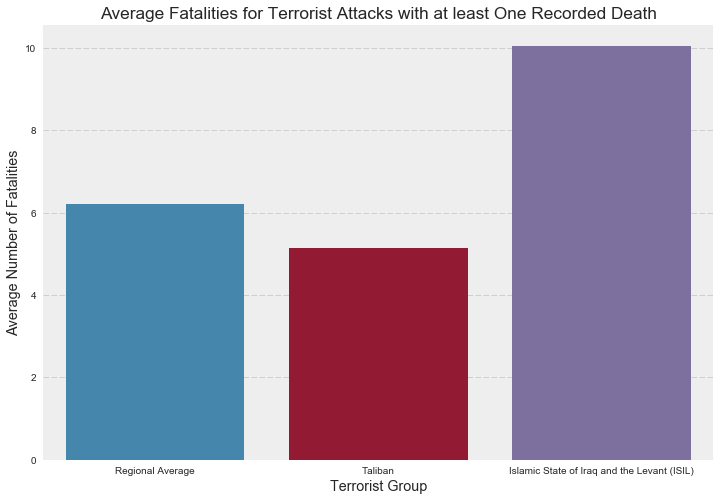

In [44]:
sns.barplot(x="group", y="nkill", data=quick_bayes_plot)
plt.title('Average Fatalities for Terrorist Attacks with at least One Recorded Death')
plt.xlabel("Terrorist Group")
plt.ylabel("Average Number of Fatalities")



In [45]:
print "Number of Observations: ", len(regional_fats)
print "Min Fatalities: ", regional_fats.min()
print "Median Fatalities: ",np.median(regional_fats)
print "Mean Fatalities: ",regional_fats.mean()
print "Max Fatalities: ",regional_fats.max()
print "Fatalities Std: ",regional_fats.std()

Number of Observations:  4647
Min Fatalities:  1.0
Median Fatalities:  2.0
Mean Fatalities:  6.21088874543
Max Fatalities:  518.0
Fatalities Std:  14.8927976769


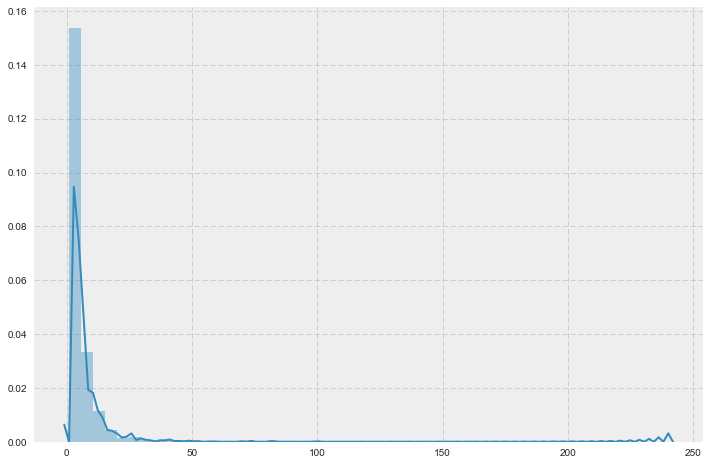

In [46]:
#Plotting distribution of fatalities per attack for the Taliban during period of interest
sns.distplot(tali_fats)

In [47]:
print "Number of Observations: ", len(tali_fats)
print "Min Fatalities: ", tali_fats.min()
print "Median Fatalities: ",np.median(tali_fats)
print "Mean Fatalities: ",tali_fats.mean()
print "Max Fatalities: ",tali_fats.max()
print "Fatalities Std: ",tali_fats.std()

Number of Observations:  2421
Min Fatalities:  1.0
Median Fatalities:  3.0
Mean Fatalities:  5.13548120611
Max Fatalities:  240.0
Fatalities Std:  8.46880131362


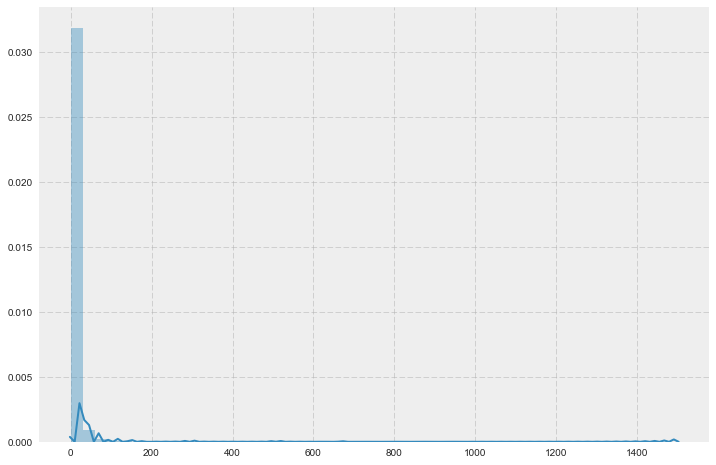

In [48]:
#Plotting distribution of fatalities per attack for ISIL during period of interest
sns.distplot(isil_fats)

In [49]:
print "Number of Observations: ", len(isil_fats)
print "Min Fatalities: ", isil_fats.min()
print "Median Fatalities: ",np.median(isil_fats)
print "Mean Fatalities: ",isil_fats.mean()
print "Max Fatalities: ",isil_fats.max()
print "Fatalities Std: ",isil_fats.std()

Number of Observations:  1801
Min Fatalities:  1.0
Median Fatalities:  4.0
Mean Fatalities:  10.0594114381
Max Fatalities:  1500.0
Fatalities Std:  45.5248048084


In [50]:
#determining mean and standard deviation of mean from regional_fats
mean_prior_fats_mean = regional_fats.mean()
mean_prior_fats_std = regional_fats.std()

print "Prior Mean Fatalities (Mean): ",mean_prior_fats_mean
print "Prior Mean Fatalities (Std): ",mean_prior_fats_std

Prior Mean Fatalities (Mean):  6.21088874543
Prior Mean Fatalities (Std):  14.8927976769


In [59]:
#Setting up conditions for MCMC distributions of fatalities per terrorist group (using pymc3 library) 
#establishing prior distributions of fatalities using regional data from prior period

#Here, setting up mean of prior distribution

with pm.Model() as model:

    t_mean = pm.Normal('taliban_mean', mean_prior_fats_mean, sd=mean_prior_fats_std)
    i_mean = pm.Normal('isil_mean', mean_prior_fats_mean, sd=mean_prior_fats_std)


In [60]:
#Setting up standard deviation of prior distribution.

# I decided to stipulate a uniform distribution for the standard deviation of fatalities, between 1 and 50, due to the
# unpredictability of terrorist attacks.

std_prior_lower = 1.0
std_prior_upper = 50.0

with model:
    
    t_std = pm.Uniform('taliban_std', lower=std_prior_lower, upper=std_prior_upper)
    i_std = pm.Uniform('isil_std', lower=std_prior_lower, upper=std_prior_upper)

In [61]:
#Setting up marginal likelihoods of observing data given prior distributions
with model:

    taliban = pm.Normal('taliban_fatalities', mu=t_mean, sd=t_std, observed=tali_fats)
    isil = pm.Normal('isil_fatalities', mu=i_mean, sd=i_std, observed=isil_fats)

In [62]:
#In comparing the two groups, I want to examine differences in mean fatalities, the standard deviation of fatalities
#per attack, as well as the effect size of the comparisons.

with model:

    diff_of_means = pm.Deterministic('difference of means', t_mean - i_mean)
    diff_of_stds = pm.Deterministic('difference of stds', t_std - i_std)
    effect_size = pm.Deterministic('effect size',
                                   diff_of_means / np.sqrt((t_std**2 + i_std**2) / 2))


In [63]:
#conducting No U-Turn Sampler MCMC

with model:
    trace = pm.sample(25000, njobs=4)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -18,055: 100%|██████████| 200000/200000 [00:32<00:00, 6151.58it/s]
Finished [100%]: Average ELBO = -18,055
100%|██████████| 25000/25000 [01:23<00:00, 301.01it/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1466c1f90>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x146902b90>], dtype=object)

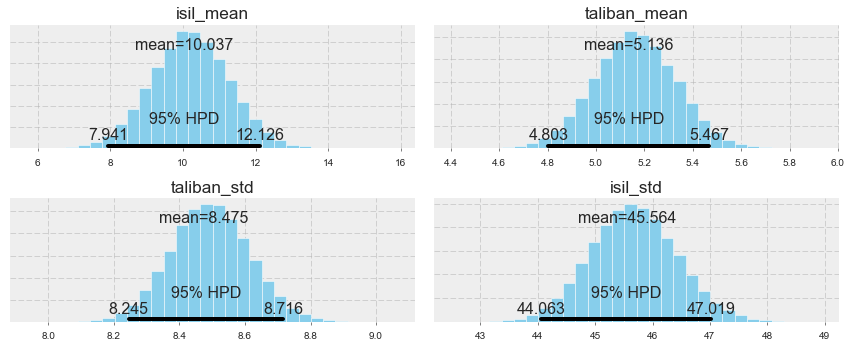

In [64]:
#Plotting Posterior Distributions

pm.plot_posterior(trace[3000:],
                  varnames=['taliban_mean', 'isil_mean', 'taliban_std', 'isil_std'],
                  color='#87ceeb')

# Following this analysis, I can determine a 95% credible interval demonstrating the mean number of fatalities in an 
# ISIL attack to be between 7.94 and 12.13, with a maximum a-posteriori estimate of 10.04 fatalities per attack. 

# I could also determine a 95% credible interval specifying the mean number of fatalities in a Taliban attack being 
# between 4.80 and 5.47, with a maximum a-posteriori estimate of 5.14 fatalities per attack.

# ISIL also appears to have a much wider standard deviation of fatalities per attack, compared to the Taliban, with
# a mean posterior standard deviation of 45.56 fatalities per attack for ISIL, compared to a mean posterior standard 
# deviation of 8.47 fatalities for the Taliban.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x146c57d10>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x146b34210>], dtype=object)

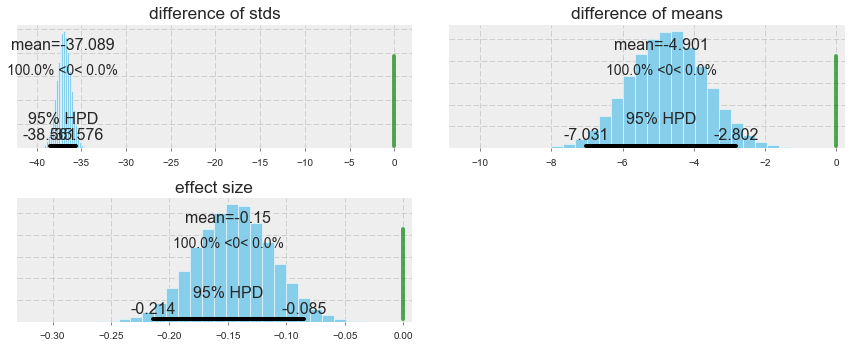

In [65]:
#Examining calculated differences of posterior means, standard deviations, and effect sizes

pm.plot_posterior(trace[3000:],
                  varnames=['difference of means', 'difference of stds', 'effect size'],
                  ref_val=0,
                  color='#87ceeb')

# Observing the results here, I can determine a significant difference in the mean number of fatalities in Taliban 
# attacks when compared to ISIL attacks. With 95% credibility, the mean difference in fatalities per attack for these
# two groups is between 2.80 and 7.03, with a maximum a-posteriori estimate of 4.90 fatalities’ difference per attack, 
# with ISIL attacks consistently producing more fatalities than Taliban attacks.

# Results also confirm a significant difference in the standard deviations calculated for each of the groups. As noted
# above, ISIL's mean posterior standard deviation distribution is significantly larger than that of the Taliban, 
# meaning it may be harder to predict the amount of carnage associated with an ISIL attack, when compared to the 
# Taliban.

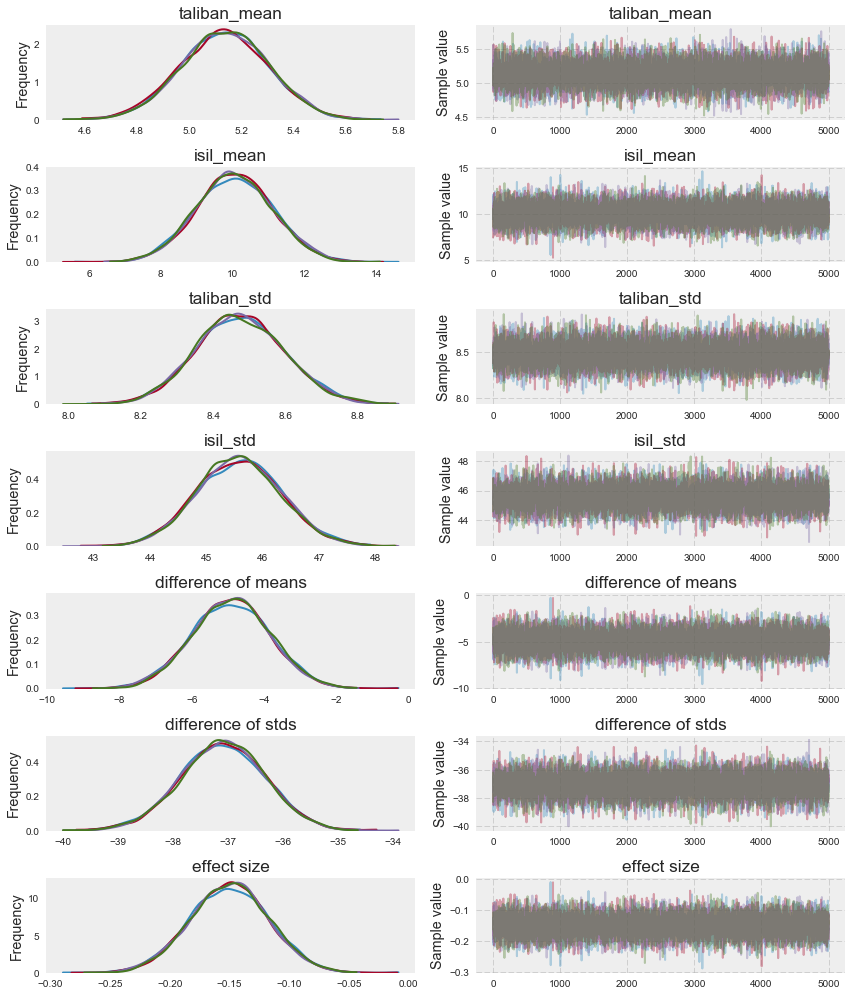

In [66]:
#plotting traces
plt.figure(figsize=(7,7))
pm.traceplot(trace[:5000])
plt.tight_layout()

## Imputing 1993 Bombing Stats

In [67]:
# returning to the data in preparation to impute the number of bombings occurring in 1993. 
data.head()

,eventid,year,month,day,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,1.970000e+11,1970,10,17,1970-10-17,0,NaN,58.0,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0.0,0.0,0.0,0.0,NaN
1,1.970000e+11,1970,6,8,1970-06-08,0,NaN,130.0,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0.0,1.0,1.0,1.0,NaN
2,1.970010e+11,1970,1,19,1970-01-19,0,NaN,160.0,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,NaN,NaN,1.0,1.0,NaN
3,1.970010e+11,1970,1,12,1970-01-12,0,NaN,78.0,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,NaN,NaN,1.0,1.0,NaN
4,1.970010e+11,1970,1,8,1970-01-08,0,NaN,101.0,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,NaN,NaN,1.0,1.0,NaN


In [68]:
# Examining total numbers of attacks per attack type
data.attacktype1_txt.value_counts()

Bombing/Explosion                      67882
Armed Assault                          35962
Assassination                          13612
Hostage Taking (Kidnapping)             8908
Facility/Infrastructure Attack          8324
Unknown                                 4967
Hostage Taking (Barricade Incident)      827
Unarmed Assault                          698
Hijacking                                481
Name: attacktype1_txt, dtype: int64

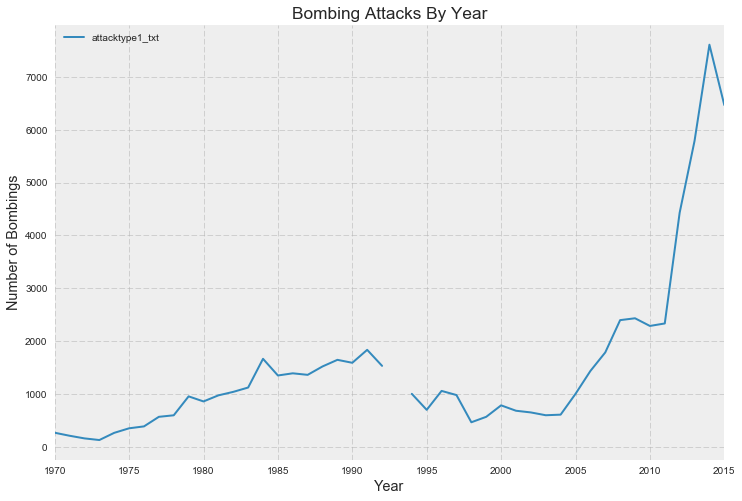

In [69]:
#Looking at bombings/explosions for all years, creating an intention gap for 1993 to illustrate missing values
bombings_years = data[data["attacktype1_txt"] == "Bombing/Explosion"]

bombplot = pd.DataFrame(bombings_years[["year", "attacktype1_txt"]].groupby(["year"]).attacktype1_txt.count())
new_val = pd.DataFrame([np.nan], columns = ["attacktype1_txt"])
bombplot = bombplot.append(new_val)
bombplot.index.values[len(bombplot.index.values)-1] = 1993
bombplot.sort_index().plot()

plt.title('Bombing Attacks By Year')
plt.xlabel("Year")
plt.ylabel("Number of Bombings")

#It's interesting to see the really big drop-off in bombings occurring right around our missing year of 1993. As such,
#there seems like a lot of room for 1993 bombing predictions.

#It's interesting how the codebook notes a rather substantial drop-off in terrorism around this time due to the breakup
#of the Soviet Union, the reunification of Germany, and the separation of Yugoslavia and Czechoslovakia

In [70]:
#using the "related" column as an arbitrary variable for easier counts of observations - filling in NaN values with 0s
data.related.fillna(0,inplace=True)

### Predicting 1993 Bombings Using All Country Data Prior to 1993

In [71]:
#Examining number of bombings recorded per country for all years through 1992, filling NaN values with 0.

bombs_country = data[(data.attacktype1_txt == "Bombing/Explosion") & (data.year < 1993)
            ].groupby(["year","country_txt"]).related.count().unstack()
bombs_country.index = pd.to_datetime(bombs_country.index, format='%Y')
bombs_country.fillna(0,inplace=True)

In [72]:
bombs_country

country_txt,Afghanistan,Albania,Algeria,Angola,Argentina,Australia,Austria,Azerbaijan,Bahrain,Bangladesh,...,Uruguay,Venezuela,West Bank and Gaza Strip,West Germany (FRG),Western Sahara,Yemen,Yugoslavia,Zaire,Zambia,Zimbabwe
year,,,,,,,,,,,,,,,,,,,,,
1970-01-01,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,...,7.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
1971-01-01,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
1972-01-01,0.0,0.0,0.0,0.0,8.0,2.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0
1973-01-01,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,7.0,0.0,0.0,1.0,0.0,0.0,0.0
1974-01-01,0.0,0.0,0.0,0.0,38.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,12.0,0.0,0.0,1.0,0.0,0.0,0.0
1975-01-01,0.0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0
1976-01-01,0.0,0.0,1.0,0.0,14.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0
1977-01-01,0.0,0.0,0.0,0.0,4.0,0.0,2.0,0.0,0.0,1.0,...,0.0,1.0,0.0,15.0,0.0,0.0,1.0,0.0,0.0,0.0
1978-01-01,0.0,0.0,0.0,2.0,11.0,2.0,0.0,0.0,0.0,0.0,...,0.0,1.0,3.0,13.0,0.0,0.0,0.0,0.0,3.0,0.0


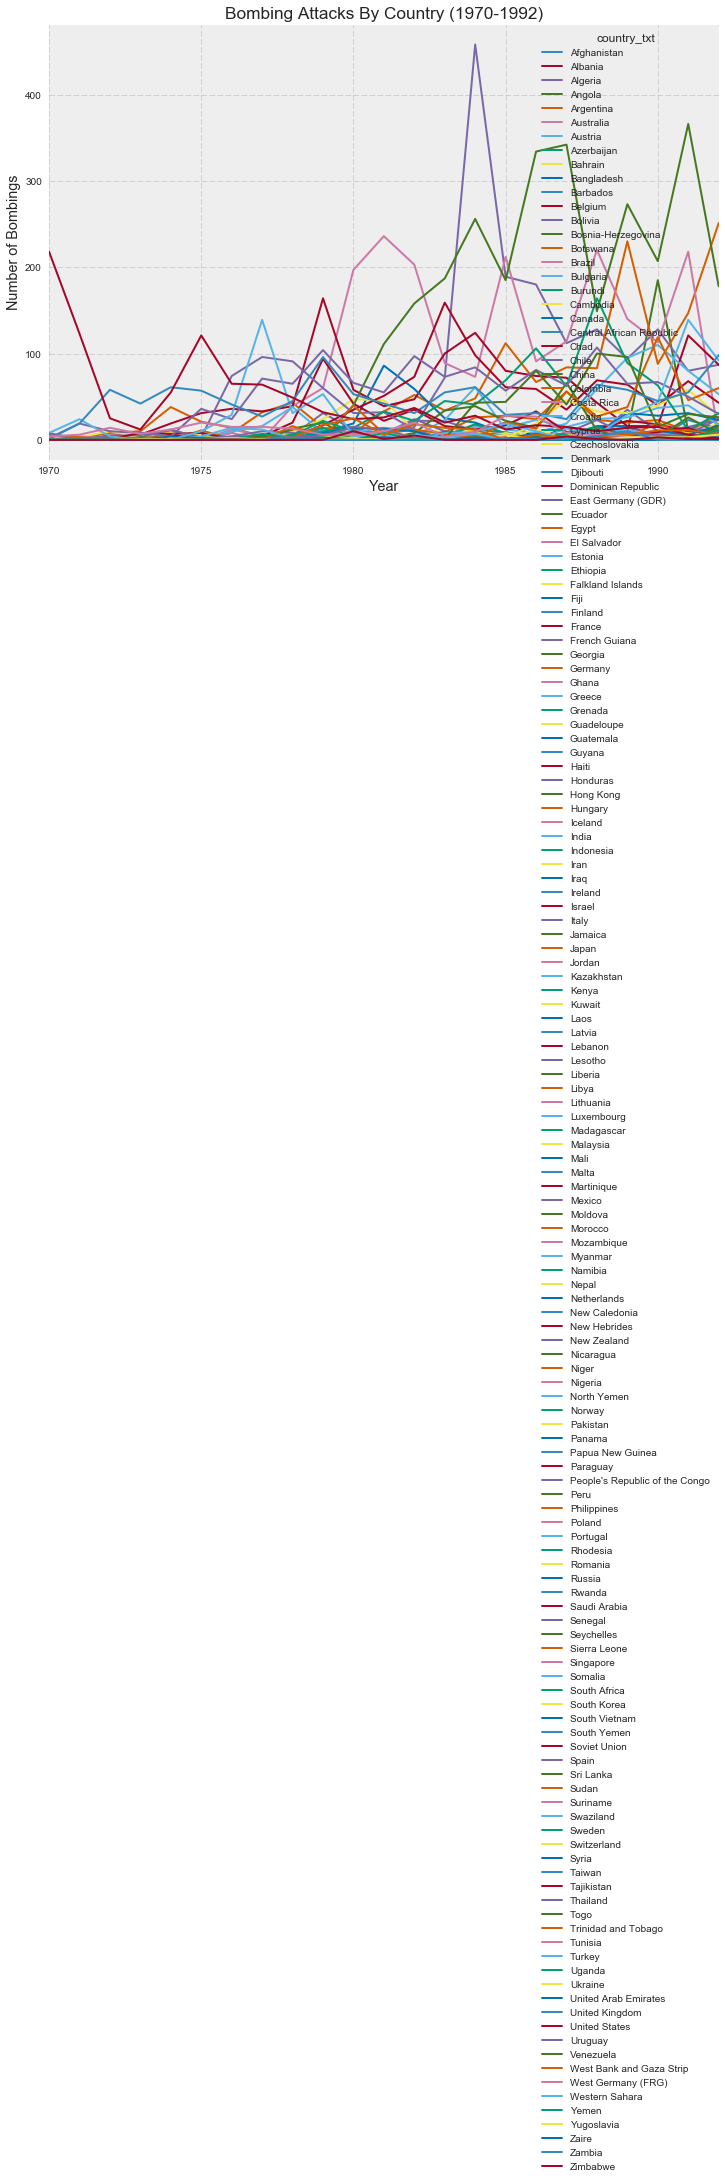

In [73]:
#plotting out all yearly bombing figures from all countries from 1970-1992
bombs_country.plot()
plt.title('Bombing Attacks By Country (1970-1992)')
plt.xlabel("Year")
plt.ylabel("Number of Bombings")

#There appears to be a slight upward trend, though the majority of countries are pretty flatly against the bottom
#of the plot.  We may end up taking a single differencing component when building our model

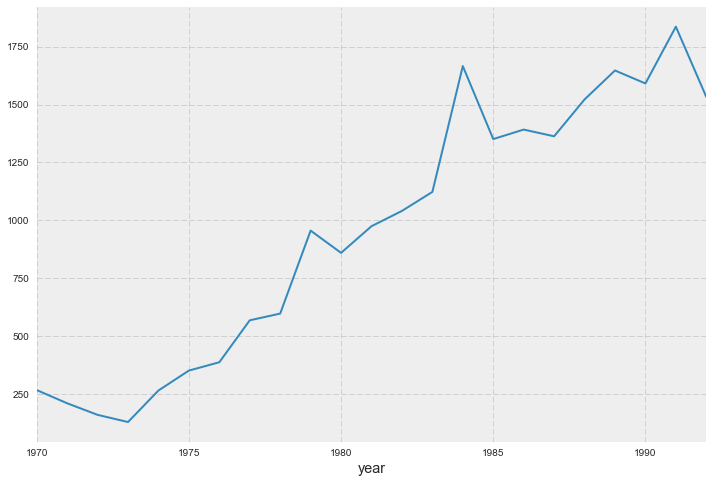

In [74]:
bombs_country.sum(axis=1).plot()
#plotting the sum of all bombings, however, there's a clear upward trend for the majority of the timeline leading up
#to 1993

In [75]:
#Looking at top countries by bombings/explosions in five years prior to 1993

countries_bombs = bombs_country.iloc[:,:152].T
countries_bombs = countries_bombs.iloc[:,18:23]
countries_bombs["Sum"] = countries_bombs.sum(axis=1)

countries_bombs.sort('Sum', ascending=False)

#Oddly, none of the countries near the top are part of the Soviet Union, or otherwise related to the dissolution of
#countries in eastern europe.  Many of them are in South America.

/Users/michaelsalmon/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  import sys


year,1988-01-01 00:00:00,1989-01-01 00:00:00,1990-01-01 00:00:00,1991-01-01 00:00:00,1992-01-01 00:00:00,Sum
country_txt,,,,,,
Peru,149.0,273.0,207.0,366.0,178.0,1173.0
Colombia,83.0,230.0,88.0,147.0,251.0,799.0
El Salvador,220.0,140.0,113.0,218.0,5.0,696.0
Chile,128.0,94.0,128.0,80.0,87.0,517.0
India,59.0,95.0,110.0,80.0,53.0,397.0
South Africa,164.0,89.0,63.0,11.0,31.0,358.0
United Kingdom,64.0,58.0,45.0,55.0,98.0,320.0
Spain,107.0,65.0,67.0,50.0,30.0,319.0
Turkey,6.0,29.0,44.0,139.0,92.0,310.0


In [76]:
#creating an average column to better examing autocorrelation info
#we'll also create a first difference component to examine whether using a difference term is warranted.
bombs_country["Average"] = bombs_country.mean(axis=1)
bombs_country["first_diff"] = bombs_country["Average"].diff(1)


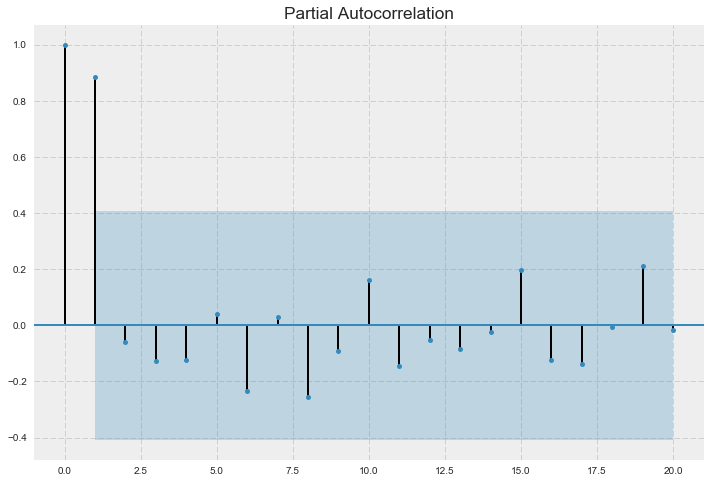

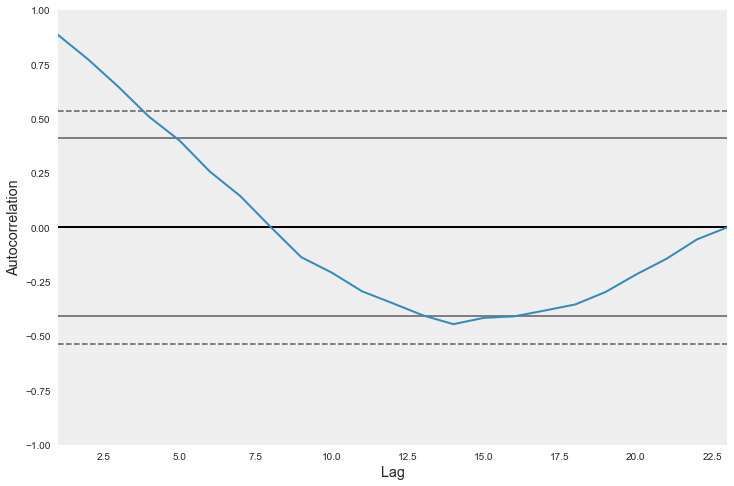

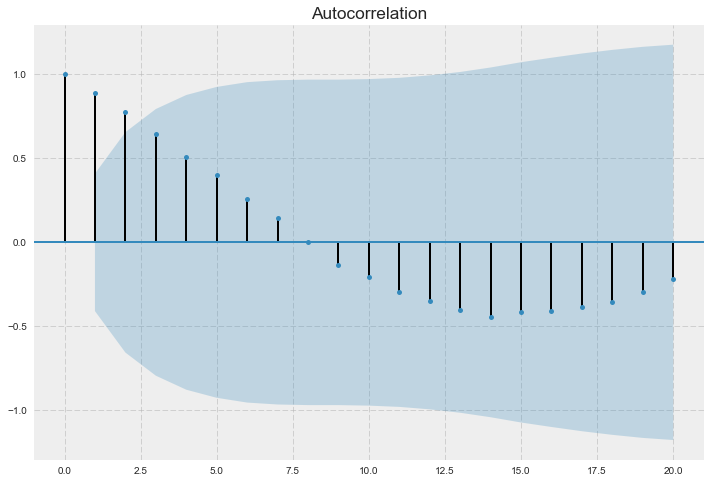

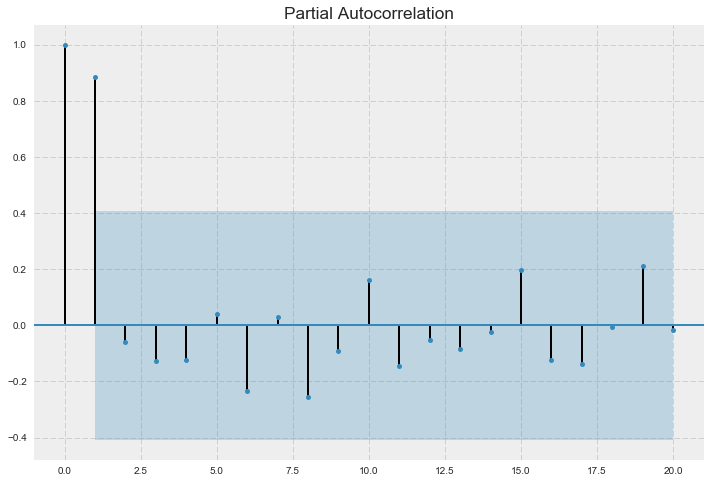

In [77]:
autocorrelation_plot(bombs_country.Average)
#not quite stationary
plot_acf(bombs_country.Average, lags=20) 
plot_pacf(bombs_country.Average, lags=20) 

#it appears there may be an AR signature. However, this is undifferenced data, and is unlikely to be stationary when
#attempting autoregression


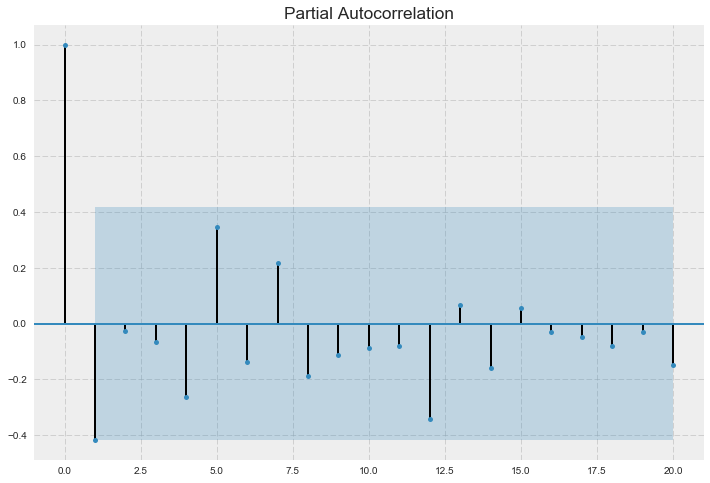

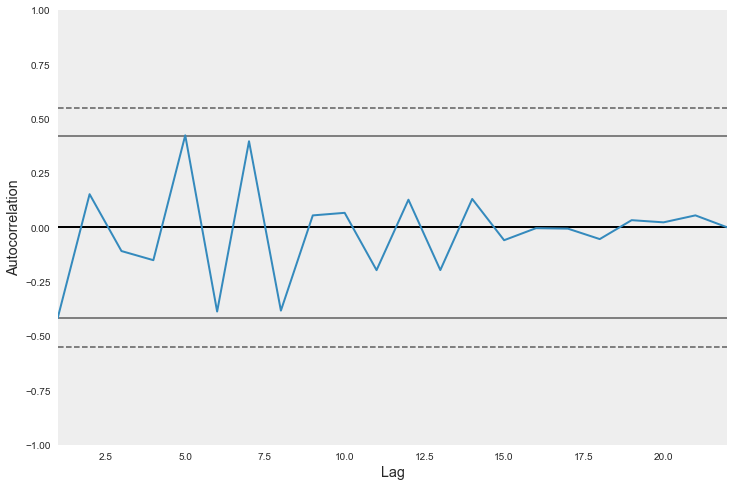

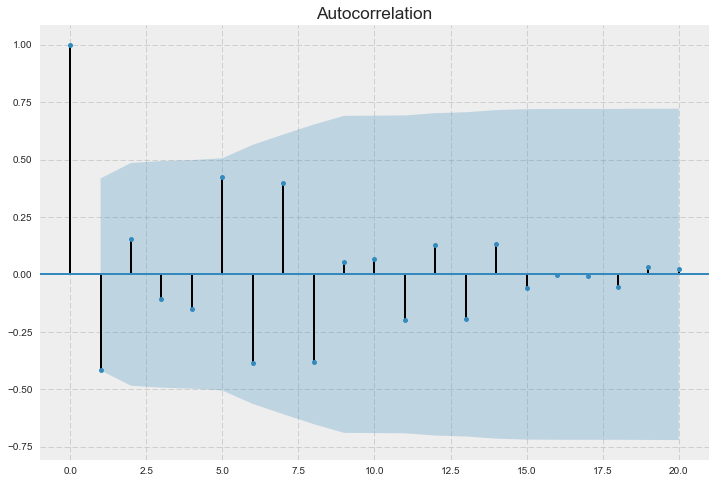

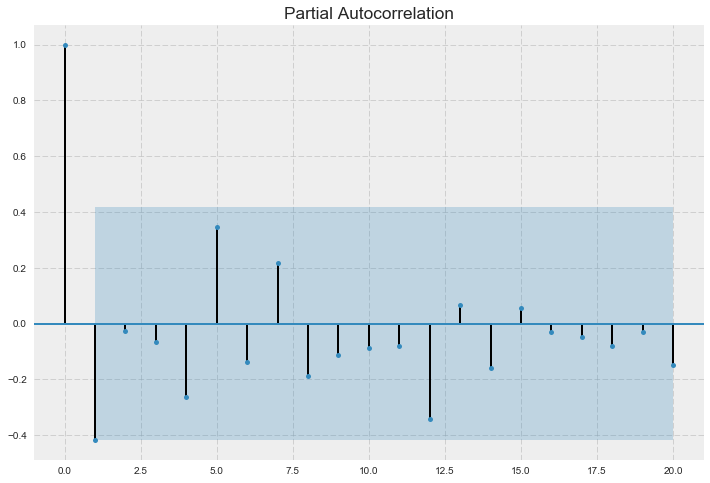

In [78]:
autocorrelation_plot(bombs_country.first_diff.dropna(inplace=False))
#using the first difference definitely shows stationary data

plot_acf(bombs_country.first_diff.dropna(inplace=False), lags=20) 
plot_pacf(bombs_country.first_diff.dropna(inplace=False), lags=20) 

#If anything, we might use a seasonal MA of 1, which would make sense due to the unpredictability of terrorist attacks.
#I initially tried a seasonal MA of 1 with a season of five years (to try capturing the upward spike around five years
#prior), but I continually received an error noting the non-invertibility of my data when attempting this. 
#This seems to be an error similar to non-stationarity when attempting autoregression. I would like to investigate the
#reasons for this in the future.


In [79]:
bombs_country.Average

year
1970-01-01     1.763158
1971-01-01     1.388158
1972-01-01     1.059211
1973-01-01     0.855263
1974-01-01     1.750000
1975-01-01     2.315789
1976-01-01     2.552632
1977-01-01     3.743421
1978-01-01     3.934211
1979-01-01     6.289474
1980-01-01     5.657895
1981-01-01     6.414474
1982-01-01     6.848684
1983-01-01     7.388158
1984-01-01    10.960526
1985-01-01     8.888158
1986-01-01     9.157895
1987-01-01     8.967105
1988-01-01    10.013158
1989-01-01    10.835526
1990-01-01    10.467105
1991-01-01    12.078947
1992-01-01    10.085526
Name: Average, dtype: float64

In [80]:
bombs_country.first_diff

year
1970-01-01         NaN
1971-01-01   -0.375000
1972-01-01   -0.328947
1973-01-01   -0.203947
1974-01-01    0.894737
1975-01-01    0.565789
1976-01-01    0.236842
1977-01-01    1.190789
1978-01-01    0.190789
1979-01-01    2.355263
1980-01-01   -0.631579
1981-01-01    0.756579
1982-01-01    0.434211
1983-01-01    0.539474
1984-01-01    3.572368
1985-01-01   -2.072368
1986-01-01    0.269737
1987-01-01   -0.190789
1988-01-01    1.046053
1989-01-01    0.822368
1990-01-01   -0.368421
1991-01-01    1.611842
1992-01-01   -1.993421
Name: first_diff, dtype: float64

In [81]:
#defining a function to test the stationarity of the data. We want to ensure the data is properly stationary before 
#generating predictions to be confident that we are making predictions based on de-trended data.

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=5,center=False).mean()
    rolstd = timeseries.rolling(window=5,center=False).std()
    
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, maxlag=4, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput 

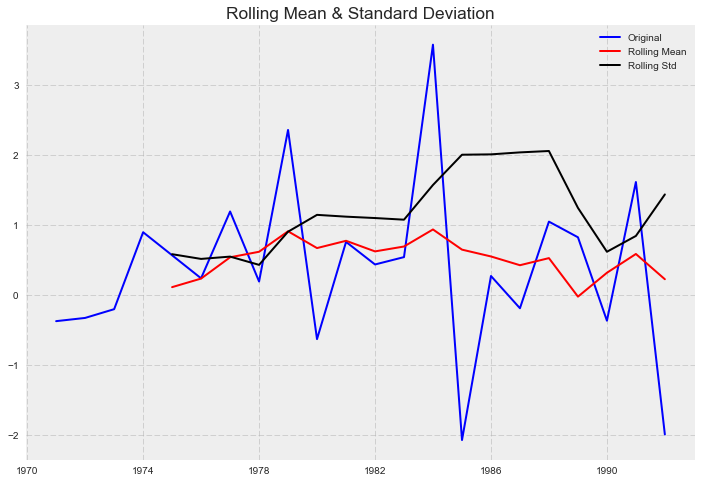

Results of Dickey-Fuller Test:
Test Statistic                -6.813958e+00
p-value                        2.081970e-09
#Lags Used                     0.000000e+00
Number of Observations Used    2.100000e+01
Critical Value (5%)           -3.013098e+00
Critical Value (1%)           -3.788386e+00
Critical Value (10%)          -2.646397e+00
dtype: float64


In [82]:
#testing stationarity of average bombings per country with singular difference

#Disclaimer, I spent a lot of time trying to find ways of imposing stationarity across individual countries' data
#(as well as individual regions below) to no great effect.  Even using second order differencing, many countries were
#still no where near having stationary data.  As much as I would have liked to develop a single (or even a few) ARIMA
#models to predict bombings by country, I could not find an effective way of doing this within the time allowed.

#As such, I created one estimate here, based off of average bombings across all countries, and did another below, 
#using an exponential weighted average of regional bombings
 
test_stationarity(bombs_country["Average"].diff(1).dropna(inplace=False))

#Yes, the data is sufficiently stationary with a single order difference.

In [83]:
#Using the SARIMAX model from Stats Models to generate a (0,1,1) ARIMA model predicting bombings for 1993. That is, 
#the model contains no autoregressive components, a single differencing component, as well as a single moving average 
#component

average_country_train = pd.DataFrame(bombs_country["Average"])

model = sm.tsa.statespace.SARIMAX(average_country_train, order=(0,1,1))
results = model.fit()
print results.summary()
print
preds = pd.DataFrame(results.forecast(1), columns = average_country_train.columns)
print "Average Est. Number of Bombings per Country in 1993: "
print preds
print
print "Total Est. Number of Bombings in 1993: " 
print preds*152

                           Statespace Model Results                           
Dep. Variable:                Average   No. Observations:                   23
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 -35.950
Date:                Wed, 10 May 2017   AIC                             75.899
Time:                        23:35:28   BIC                             78.170
Sample:                    01-01-1970   HQIC                            76.470
                         - 01-01-1992                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1831      0.231     -0.793      0.428      -0.636       0.269
sigma2         1.5353      0.360      4.263      0.000       0.829       2.241
Ljung-Box (Q):                       29.83   Jarque-

In [84]:
#When applying the expected average bombings per country in 1993 by the number of observed countries, the model 
#predicts a total of 1580 bombings/explosions in 1993.

### Predicting 1993 Bombings Using Regional Bombing Data Prior to from 1985-1992

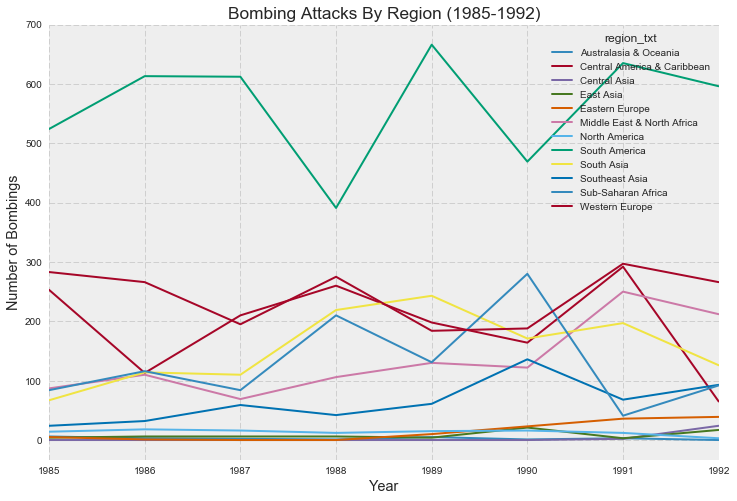

In [85]:
#Estimating 1993 bombings using regional bombing data from 1985 to 1992.  I chose this period as it appeared to be
#the most "stationary" period when examining a plot of regional bombings over time

bombs = data[(data.attacktype1_txt == "Bombing/Explosion") & (data.year >= 1985) & (data.year < 1993)
            ].groupby(["year","region_txt"]).related.count().unstack()
bombs.index = pd.to_datetime(bombs.index, format='%Y')
bombs.fillna(0,inplace=True)

bombs.plot()
plt.title('Bombing Attacks By Region (1985-1992)')
plt.xlabel("Year")
plt.ylabel("Number of Bombings")


In [86]:
#creating an average column to better examing autocorrelation info
#we'll also create a first difference component to examine whether using a difference term is warranted.
bombs["Sum"] = bombs.sum(axis=1)
bombs["Average"] = bombs.iloc[:,:12].mean(axis=1)
bombs["first_diff"] = bombs["Average"].diff(1)


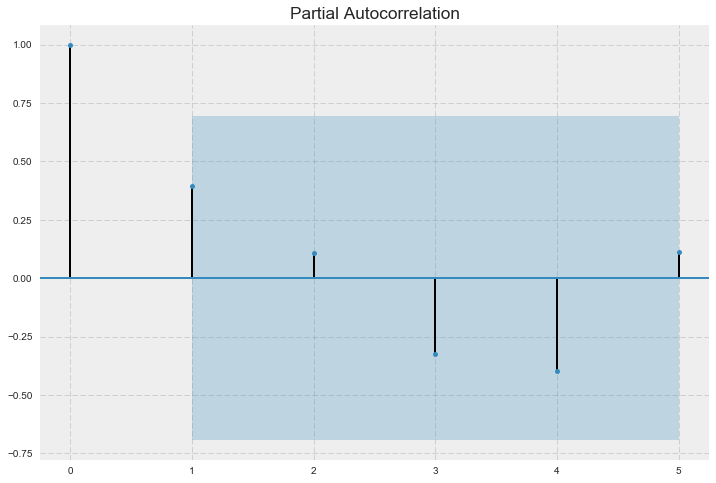

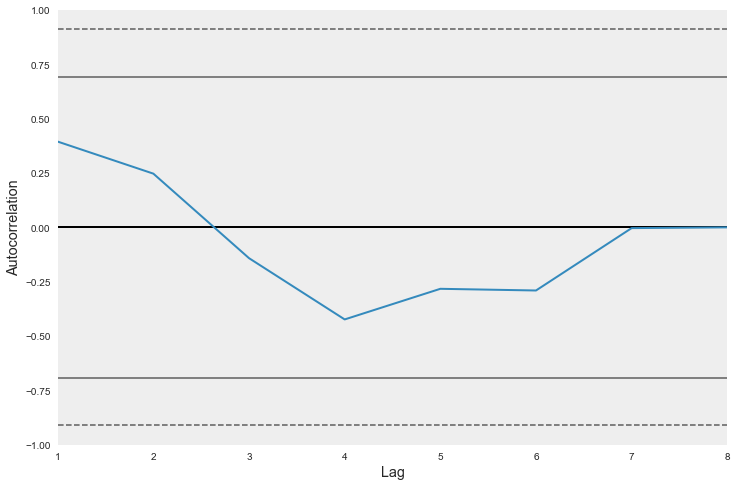

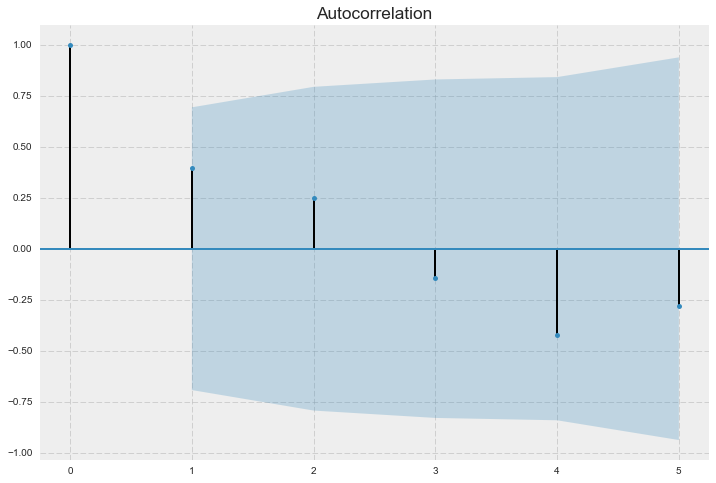

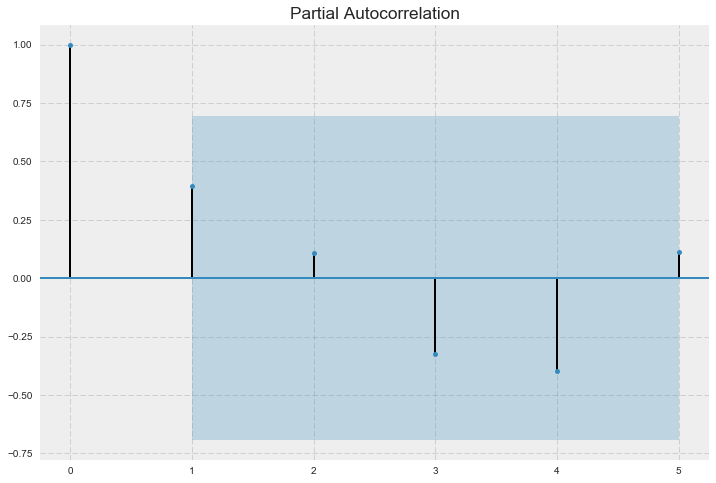

In [87]:
autocorrelation_plot(bombs.Average)
plot_acf(bombs.Average, lags=5) 
plot_pacf(bombs.Average, lags=5) 

#with no differencing of the data, it appears there may be an AR signature. If we use this data, there could be a 
#single AR term for trying to impute 1993

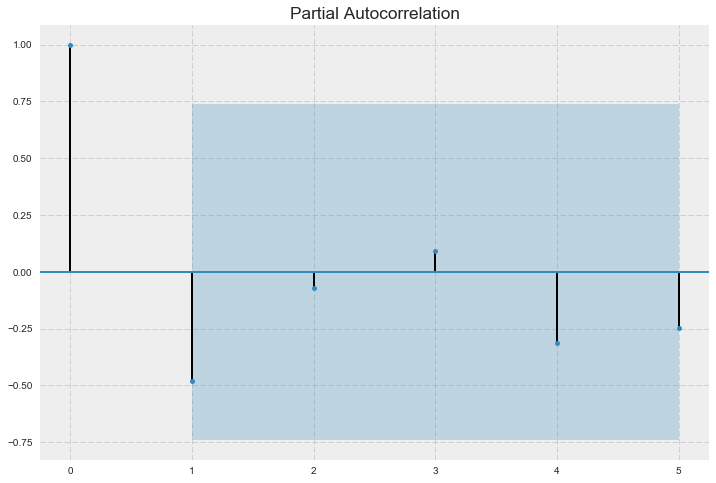

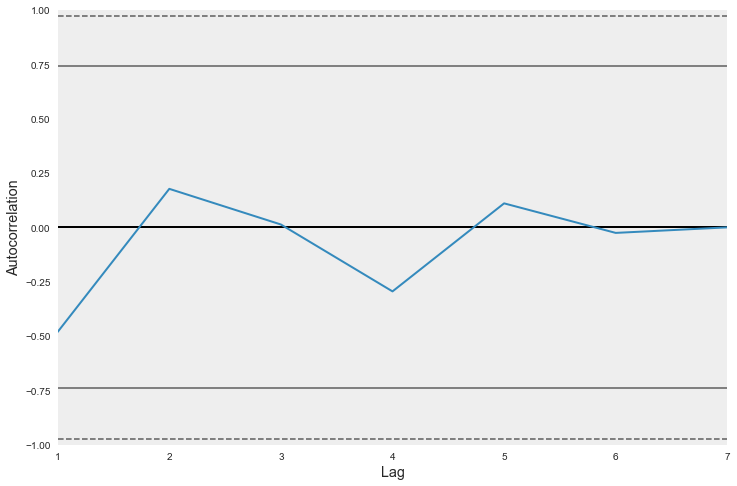

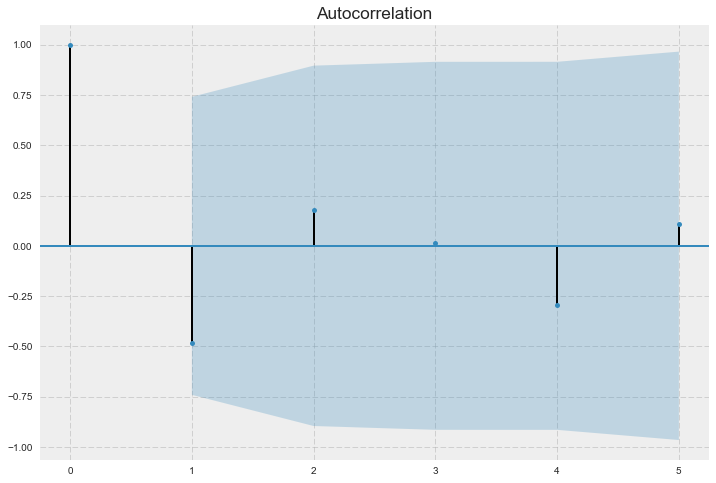

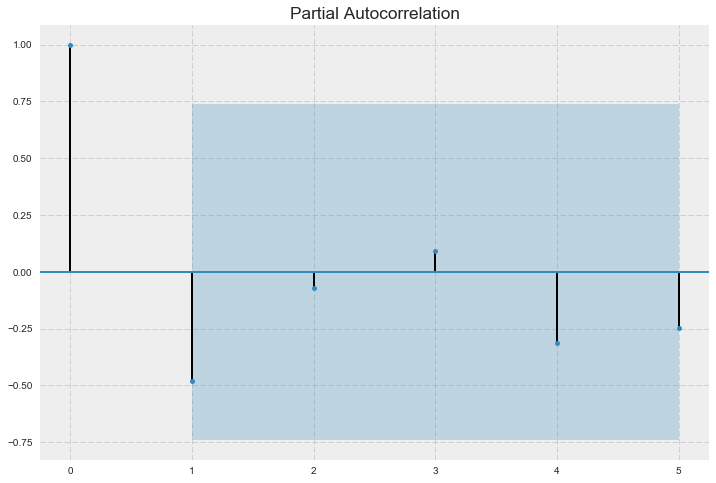

In [88]:
autocorrelation_plot(bombs.first_diff.dropna(inplace=False))
#using the first difference definitely shows stationary data

plot_acf(bombs.first_diff.dropna(inplace=False), lags=5) 
plot_pacf(bombs.first_diff.dropna(inplace=False), lags=5) 

#If anything, I would have liked to use a seasonal ARIMA with a season of five years, and a seasonal MA of 1. However,
#I got the same non-invertibility error as when I worked with the country data above.  



In [89]:
#Looking at number of bombings per region in the year 1985-1992 (only the first five years displayed here)
bombs.head()

region_txt,Australasia & Oceania,Central America & Caribbean,Central Asia,East Asia,Eastern Europe,Middle East & North Africa,North America,South America,South Asia,Southeast Asia,Sub-Saharan Africa,Western Europe,Sum,Average,first_diff
year,,,,,,,,,,,,,,,
1985-01-01,6.0,253.0,0.0,4.0,5.0,87.0,14.0,524.0,67.0,24.0,84.0,283.0,1351.0,112.583333,NaN
1986-01-01,3.0,113.0,0.0,6.0,1.0,110.0,18.0,613.0,114.0,32.0,116.0,266.0,1392.0,116.000000,3.416667
1987-01-01,2.0,210.0,0.0,6.0,0.0,69.0,16.0,612.0,110.0,59.0,84.0,195.0,1363.0,113.583333,-2.416667
1988-01-01,1.0,260.0,0.0,6.0,0.0,106.0,12.0,391.0,219.0,42.0,210.0,275.0,1522.0,126.833333,13.250000
1989-01-01,5.0,198.0,0.0,4.0,10.0,130.0,15.0,666.0,243.0,61.0,131.0,184.0,1647.0,137.250000,10.416667


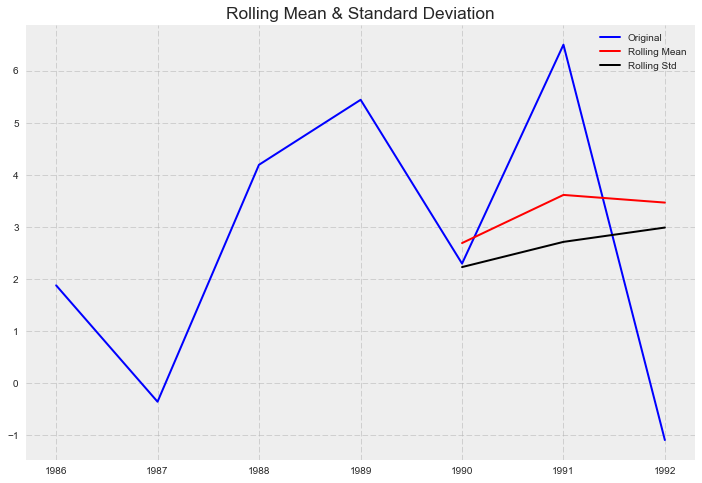

Results of Dickey-Fuller Test:
Test Statistic                -2.640225
p-value                        0.084965
#Lags Used                     0.000000
Number of Observations Used    6.000000
Critical Value (5%)           -3.646238
Critical Value (1%)           -5.354256
Critical Value (10%)          -2.901198
dtype: float64


In [91]:
#In determining a means of creating stationarity within the data, I imposed an exponentially weighted mean on the 
#column of average bombings by region. Apart from establishing stationarity within the data, it also made sense on an
#intuitive level to weigh more recent years' of observations more heavily than those further in the distance, due to
#shifting political circumstances having more immediate impacts on near-temporal events than far-temporal events.

test_stationarity(bombs["Average"].ewm(ignore_na=True,span=10,min_periods=0,adjust=True).mean().
                  diff(1).dropna(inplace=False))


In [92]:
#Utilizing an exponential weighted mean of average bombings across all regions to predict number of bombings
#in 1993

average_train = pd.DataFrame(bombs["Average"].ewm(ignore_na=True,span=10,min_periods=0,adjust=True).mean())

model = sm.tsa.statespace.SARIMAX(average_train, order=(0,1,1))
results = model.fit()
print results.summary()
print
preds = pd.DataFrame(results.forecast(1), columns = average_train.columns)
print "Average Est. Number of Bombings per Region in 1993: "
print preds
print
print "Total Est. Number of Bombings in 1993: " 
print preds*12

                           Statespace Model Results                           
Dep. Variable:                Average   No. Observations:                    8
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 -18.858
Date:                Wed, 10 May 2017   AIC                             41.716
Time:                        23:35:42   BIC                             41.875
Sample:                    01-01-1985   HQIC                            40.644
                         - 01-01-1992                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2656      0.482      0.551      0.582      -0.679       1.210
sigma2        12.6758      9.903      1.280      0.201      -6.733      32.085
Ljung-Box (Q):                        6.69   Jarque-

In [93]:
#When applying the expected average bombings per country in 1993 to the number of observed regions, the model predicts
#a total of 1568 bombings/explosions in 1993.